# AAI521 Project- Crop Pest Detection

### Contributers:
### Callum Lamb, Lakshmi Deepti Pamula, Divya Kamath

### Project Goal:
The objective of this project is to build a computer vision system capable of accurately detecting and classifying crop-damaging pests using the AgroPest-12 dataset from Kaggle (rupankarmajumdar/crop-pests-dataset). We develop a YOLO-based object detection model that can both locate pests in agricultural images and identify the correct species among 12 pest classes.
This project includes:

*   Preparing and analyzing the dataset (EDA)
*   Converting annotations into YOLO format
*   Training multiple YOLO models
*   Evaluating model performance using precision, recall, mAP, and qualitative visualization
*    Analyzing challenges such as class imbalance, small-object detection, and real-world variability

The final goal is to determine how effectively the model can detect pests under diverse environmental and imaging conditions, supporting more efficient agricultural monitoring and interventio







# AAI521 AgroPest-12 Notebook: Project Setup, EDA, and Pre-processing

This notebook provides a single-file workflow for the AgroPest-12 crop pests dataset from Kaggle (`rupankarmajumdar/crop-pests-dataset`). It covers the initial project setup, exploratory data analysis (EDA), and data pre-processing steps, adhering to the specified constraints for Google Colab environments and GitHub integration.

**Scope:** Project Selection & Setup, EDA, and Pre-processing.

**Constraints:**
*   All code lives within this single notebook (no external `.py` files, no separate configs).
*   All data is kept under `/content/...` to avoid large files in GitHub.
*   Figures are saved to `/content/AAI521_AgroPest12/figures`.
*   No secrets are printed (e.g., `kaggle.json`).
*   Brief inline comments and 1-line summaries are included after each major step.
*   A short parenthetical plain-language gloss is added after jargon (e.g., “mAP (average precision score)”).

#STEP 1 — Project Setup and Environment Configuration
This first cell initializes the Colab environment by defining top-level paths, creating necessary directories, setting random seeds for reproducibility, and installing essential Python dependencies. It ensures a consistent and controlled environment for the subsequent data analysis tasks.

In [6]:
PROJECT_NAME = "AAI521_AgroPest12"
BASE_DIR = "/content"              # keep data ephemeral in Colab
PROJ_DIR = f"{BASE_DIR}/{PROJECT_NAME}"
DATA_DIR = f"{PROJ_DIR}/datasets/agropest12"   # ignored by .gitignore
FIG_DIR  = f"{PROJ_DIR}/figures"

import os, random, pathlib
from pathlib import Path
for p in [PROJ_DIR, DATA_DIR, FIG_DIR]:
    os.makedirs(p, exist_ok=True)

# Reproducibility (seed = makes results repeatable)
import numpy as np
import torch
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Minimal deps for EDA + Kaggle API
!pip -q install kaggle pandas numpy matplotlib opencv-python pillow
print("Setup complete. Project dir:", PROJ_DIR)


Setup complete. Project dir: /content/AAI521_AgroPest12


## STEP 2 — Dataset Access

This section will cover accessing and downloading the dataset from Kaggle.

### Install Kaggle Library

In [ ]:
print('Installing Kaggle library...')
!pip install kaggle

Installing Kaggle library...



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Kaggle API Key Setup

To download datasets from Kaggle, you need to authenticate using your Kaggle API key. Follow these steps:

1.  Go to your Kaggle account page (kaggle.com/your_username/account).
2.  Under the "API" section, click "Create New API Token". This will download a `kaggle.json` file.
3.  In Colab, go to the left panel, click on the 🔑 (Secrets) icon.
4.  Click "Add new secret".
5.  For the `Name`, enter `KAGGLE_USERNAME` and for the `Value`, enter your Kaggle username (found in the `kaggle.json` file under `username`).
6.  Add another secret.
7.  For the `Name`, enter `KAGGLE_KEY` and for the `Value`, enter your Kaggle API key (found in the `kaggle.json` file under `key`).
8.  Make sure to enable "Notebook access" for both secrets.

Once configured, the following code will set up your Kaggle credentials for programmatic access.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
# Step 2: move kaggle.json to ~/.kaggle and fix permissions
import os, shutil, stat

kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

source = "kaggle.json"  # the file you just uploaded
dest = os.path.join(kaggle_dir, "kaggle.json")

shutil.move(source, dest)
os.chmod(dest, 0o600)


In [5]:
# comment: Configure Kaggle API in a shared Colab notebook.
# comment: Each user must have their own kaggle.json from Kaggle → Account → "Create New API Token".

import os, json
from google.colab import files

kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_path = os.path.join(kaggle_dir, "kaggle.json")
os.makedirs(kaggle_dir, exist_ok=True)

# comment: If kaggle.json is not already present in this runtime, ask the user to upload it.
if not os.path.exists(kaggle_path):
    print("Please upload your kaggle.json file (you only see your own file).")
    uploaded = files.upload()          # user chooses kaggle.json
    os.replace("kaggle.json", kaggle_path)
    os.chmod(kaggle_path, 0o600)

# comment: Optionally read username/key into variables if later code wants them.
with open(kaggle_path, "r") as f:
    creds = json.load(f)

KAGGLE_USERNAME = creds["username"]
KAGGLE_KEY = creds["key"]
print("Kaggle API is configured for:", KAGGLE_USERNAME)


Kaggle API is configured for: deeptipamula


### Download Dataset

Please provide the Kaggle dataset identifier. You can find this in the URL of the dataset page (e.g., `"owner/dataset-name"` from `kaggle.com/owner/dataset-name`).

In [7]:
DATASET_SLUG = "rupankarmajumdar/crop-pests-dataset" # @param {type:"string"}

print(f'Downloading dataset {DATASET_SLUG} to {DATA_DIR}...')
# Use !kaggle datasets download command with --unzip
!kaggle datasets download -d {DATASET_SLUG} -p "{DATA_DIR}" --unzip

#print('\nDataset download and unzip complete. Listing contents:')
#!ls -lah "{DATA_DIR}" | head -n 60

Dataset URL: https://www.kaggle.com/datasets/rupankarmajumdar/crop-pests-dataset
License(s): MIT
 96% 514M/537M [00:06<00:00, 114MB/s] 
100% 537M/537M [00:06<00:00, 89.9MB/s]


## STEP 3 — Dataset Structure Probe and Style Detection

This cell automatically detects the style of the dataset (e.g., YOLO detection, classification) based on its file and directory structure. It sets a global `MODE` variable and prints a summary of the findings.

In [8]:
import os
from pathlib import Path

# Define common image extensions (for finding image files)
IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')
LABEL_EXTENSION = '.txt'

MODE = "unknown" # Global variable to store detected dataset style
image_files = []
label_files = [] # Only populated if MODE becomes detection_yolo

print("Detecting dataset style...")

# --- 1. Check for YOLO-style detection (strong indicators: data.yaml or images/labels folders) ---
# Check for 'data.yaml', a strong indicator for YOLO format
data_yaml_path = Path(DATA_DIR) / 'data.yaml'
has_data_yaml = data_yaml_path.exists()

# Check for 'images' and 'labels' directories within 'train', 'valid', 'test' splits
has_yolo_structure_in_splits = False
for split_dir_name in ['train', 'valid', 'test']:
    split_path = Path(DATA_DIR) / split_dir_name
    if split_path.is_dir():
        if (split_path / 'images').is_dir() and (split_path / 'labels').is_dir():
            has_yolo_structure_in_splits = True
            break # Found YOLO structure in at least one split

if has_data_yaml or has_yolo_structure_in_splits:
    MODE = "detection_yolo"
    # Collect all image and label files recursively for YOLO
    for root, _, files in os.walk(DATA_DIR):
        current_path = Path(root)
        for file in files:
            file_path = current_path / file
            if file_path.suffix.lower() in IMAGE_EXTENSIONS:
                image_files.append(file_path)
            # Only consider .txt files as labels if 'labels' is part of the path
            elif file_path.suffix.lower() == LABEL_EXTENSION and 'labels' in file_path.parts:
                label_files.append(file_path)
else:
    # --- 2. If not YOLO, check for Classification-style (class-named folders with images) ---
    classification_detected = False
    # Check within train/valid/test splits first (e.g., DATA_DIR/train/class1/img.jpg)
    for split_dir_name in ['train', 'valid', 'test']:
        split_path = Path(DATA_DIR) / split_dir_name
        if split_path.is_dir():
            for entry in split_path.iterdir():
                if entry.is_dir(): # This is a potential class folder
                    # Check if it contains image files
                    if any(f.suffix.lower() in IMAGE_EXTENSIONS for f in entry.iterdir() if f.is_file()):
                        classification_detected = True
                        break # Found a class folder with images
            if classification_detected:
                break

    # If not found in splits, check directly under DATA_DIR for class folders
    if not classification_detected:
        for entry in Path(DATA_DIR).iterdir():
            if entry.is_dir(): # This is a potential class folder
                # Check if it contains image files
                if any(f.suffix.lower() in IMAGE_EXTENSIONS for f in entry.iterdir() if f.is_file()):
                    classification_detected = True
                    break # Found a class folder with images

    if classification_detected:
        MODE = "classification"
        # Collect all image files recursively for classification
        for root, _, files in os.walk(DATA_DIR):
            for file in files:
                file_path = Path(root) / file
                if file_path.suffix.lower() in IMAGE_EXTENSIONS:
                    image_files.append(file_path)
    else:
        # --- 3. Fallback to Unknown if neither YOLO nor Classification patterns are found ---
        MODE = "unknown"
        # Still collect any image files found, for the summary
        for root, _, files in os.walk(DATA_DIR):
            for file in files:
                file_path = Path(root) / file
                if file_path.suffix.lower() in IMAGE_EXTENSIONS:
                    image_files.append(file_path)


# --- Print Summary --- (concise summary of findings)
print(f"\nDetected dataset style: {MODE}")
print(f"Total candidate image files found: {len(image_files)}")

if MODE == "detection_yolo":
    print(f"Total label files found: {len(label_files)}")
    if image_files:
        print("Example image paths:")
        for img_path in image_files[:3]: # Display first 3 example image paths
            print(f"- {img_path.relative_to(DATA_DIR)}")
    if label_files:
        print("Example label paths:")
        for lbl_path in label_files[:3]: # Display first 3 example label paths
            print(f"- {lbl_path.relative_to(DATA_DIR)}")
elif MODE == "classification":
    if image_files:
        print("Example image paths:")
        for img_path in image_files[:3]: # Display first 3 example image paths
            print(f"- {img_path.relative_to(DATA_DIR)}")
else: # Unknown mode
    if image_files:
        print("Example image paths (found but type unknown):")
        for img_path in image_files[:3]: # Display first 3 example image paths
            print(f"- {img_path.relative_to(DATA_DIR)}")
    else:
        print("No image files found.")
    print("Consider checking DATA_DIR content or specifying dataset type manually if needed.")

# MODE is now a global variable accessible by subsequent cells.

Detecting dataset style...

Detected dataset style: detection_yolo
Total candidate image files found: 13143
Total label files found: 13143
Example image paths:
- train/images/wasp-530-_jpg.rf.9c91636d276163605baa9c155f70b177.jpg
- train/images/bees-288-_jpg.rf.1ea59410749c999c39d6bf6319ad7457.jpg
- train/images/ants-12-_jpg.rf.f1046e5aeed1387191f2c12f46950bd3.jpg
Example label paths:
- train/labels/slug-12-_jpg.rf.035a35bfe9fb8ce466ab7b018218d0f9.txt
- train/labels/earwig-135-_jpg.rf.e7196dc13b2e00f6737082cef2f06894.txt
- train/labels/bees-21-_jpg.rf.df17493f21726a3cb408c0af30664eea.txt


# Task
Load class names from the `data.yaml` file located at `/content/AAI521_AgroPest12/datasets/agropest12/data.yaml` and parse all YOLO-formatted label files in `/content/AAI521_AgroPest12/datasets/agropest12` to extract bounding box coordinates and class IDs for all images. Then, analyze and visualize the distribution of object classes, calculate and visualize bounding box statistics (absolute/relative widths, heights, aspect ratios) using histograms and scatter plots, and generate a grid of sample images with overlaid bounding boxes and labels to visually inspect the annotations. Finally, summarize these EDA findings and prepare for pre-processing, including confirming train/val/test splits and planning augmentations.

## Load Class Names and Annotations

### Subtask:
Load class names from the `data.yaml` file and parse all YOLO-formatted label files to extract bounding box coordinates and class IDs for all images.


**Reasoning**:
First, import necessary libraries like `yaml` for parsing the `data.yaml` file and `pandas` for creating the DataFrame. Then, define the `data.yaml` path and load its content to extract class names. Finally, iterate through label files, find corresponding image paths, parse bounding box details, and store them in a list before converting to a pandas DataFrame.



In [9]:
import yaml
import pandas as pd
from pathlib import Path
import os

print("Loading class names from data.yaml...")
data_yaml_path = Path(DATA_DIR) / 'data.yaml'

# Check if data.yaml exists before proceeding
if not data_yaml_path.exists():
    raise FileNotFoundError(f"data.yaml not found at {data_yaml_path}. Please ensure the dataset is downloaded and structured correctly.")

with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml.get('names', [])
print(f"Loaded {len(class_names)} class names: {class_names}")

# Prepare a mapping from image stem (filename without extension) to its full path
# This helps in quickly finding the corresponding image for a given label file.
image_stem_to_path = {p.stem: p for p in image_files}

all_annotations_data = []

print("Parsing YOLO-formatted label files...")

for label_file_path in label_files:
    label_stem = label_file_path.stem

    # Try to find the corresponding image path using the stem
    image_file_path = image_stem_to_path.get(label_stem)

    if image_file_path is None:
        # This should ideally not happen if image_files and label_files are well-matched
        print(f"Warning: Could not find corresponding image for label file: {label_file_path}. Skipping.")
        continue

    try:
        with open(label_file_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    center_x, center_y, width, height = map(float, parts[1:])

                    # Ensure class_id is within bounds of class_names list
                    if 0 <= class_id < len(class_names):
                        class_name = class_names[class_id]
                    else:
                        class_name = f"unknown_class_{class_id}"
                        print(f"Warning: Class ID {class_id} out of bounds for {label_file_path}.\nAvailable classes: {class_names}")

                    all_annotations_data.append({
                        'image_path': str(image_file_path.relative_to(DATA_DIR)), # Store relative path for cleaner DataFrame
                        'label_file_path': str(label_file_path.relative_to(DATA_DIR)),
                        'class_id': class_id,
                        'class_name': class_name,
                        'center_x': center_x,
                        'center_y': center_y,
                        'width': width,
                        'height': height
                    })
                else:
                    print(f"Warning: Malformed line in {label_file_path}: {line.strip()}")
    except Exception as e:
        print(f"Error processing {label_file_path}: {e}")

# Convert to Pandas DataFrame
if all_annotations_data:
    annotations_df = pd.DataFrame(all_annotations_data)
    print(f"Successfully parsed {len(annotations_df)} annotations into a DataFrame.")
    print("Annotation DataFrame head:")
    print(annotations_df.head())
else:
    annotations_df = pd.DataFrame()
    print("No annotations were parsed. The annotations_df is empty.")

Loading class names from data.yaml...
Loaded 12 class names: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']
Parsing YOLO-formatted label files...
Successfully parsed 17312 annotations into a DataFrame.
Annotation DataFrame head:
                                          image_path  \
0  train/images/slug-12-_jpg.rf.035a35bfe9fb8ce46...   
1  train/images/earwig-135-_jpg.rf.e7196dc13b2e00...   
2  train/images/bees-21-_jpg.rf.df17493f21726a3cb...   
3  train/images/wasp-863-_jpg.rf.75ee4ccbcc5e3d6d...   
4  train/images/snail-86-_jpg.rf.c2c8a0d799e69a9f...   

                                     label_file_path  class_id class_name  \
0  train/labels/slug-12-_jpg.rf.035a35bfe9fb8ce46...         8      Slugs   
1  train/labels/earwig-135-_jpg.rf.e7196dc13b2e00...         5    Earwigs   
2  train/labels/bees-21-_jpg.rf.df17493f21726a3cb...         1       Bees   
3  train/labels/wasp-863-_jpg.rf.75ee4cc

## Analyze Class Distribution

### Subtask:
Calculate and visualize the distribution of object classes within the dataset using bar plots to show class frequency.


**Reasoning**:
To visualize the class distribution, I will count the occurrences of each class name in the `annotations_df` and then create a bar plot using `seaborn` and `matplotlib` to display these counts, ensuring proper labeling and title for clarity.



Calculating and visualizing class distribution...


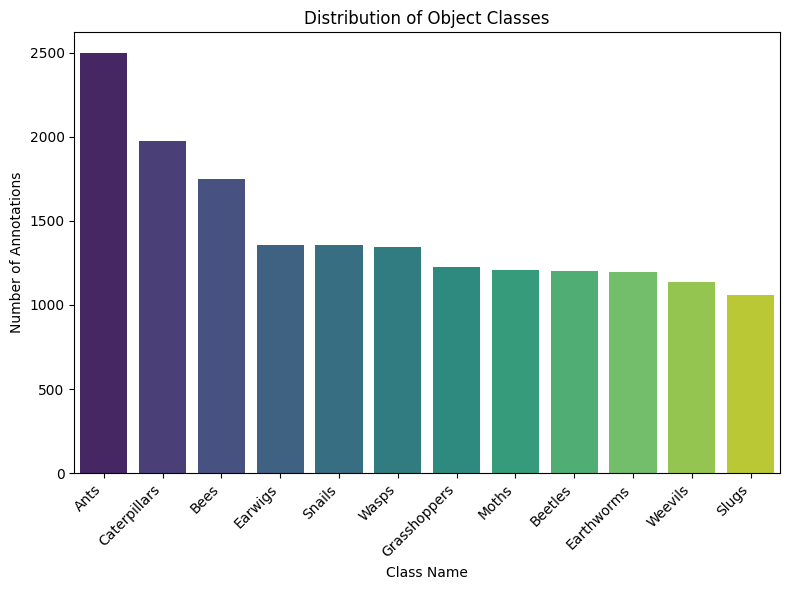

Class distribution analysis complete.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Calculating and visualizing class distribution...")

# Count the occurrences of each class_name
class_counts = annotations_df['class_name'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis', hue=class_counts.index, legend=False)

# Label the axes and add a title
plt.xlabel('Class Name')
plt.ylabel('Number of Annotations')
plt.title('Distribution of Object Classes')

# Rotate x-axis labels for better readability if many classes
plt.xticks(rotation=45, ha='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

print("Class distribution analysis complete.")

## Analyze Bounding Box Statistics

### Subtask:
Extract and analyze various statistics about bounding boxes, including their absolute and relative widths, heights, and aspect ratios. Visualize these distributions using histograms and scatter plots.


**Reasoning**:
To analyze bounding box statistics, I first need to retrieve the actual image dimensions for each image referenced in the `annotations_df`. This will allow me to convert the normalized YOLO bounding box coordinates (center_x, center_y, width, height) into absolute pixel values and calculate absolute bounding box dimensions and aspect ratios.



In [11]:
from PIL import Image
import numpy as np


# 1. Create an empty dictionary to store image dimensions
image_dims_cache = {}

# 2. Iterate through unique image_path entries and get dimensions
for image_rel_path in annotations_df['image_path'].unique():
    full_image_path = Path(DATA_DIR) / image_rel_path
    try:
        with Image.open(full_image_path) as img:
            width, height = img.size
            image_dims_cache[image_rel_path] = (width, height)
    except FileNotFoundError:
        print(f"Warning: Image not found at {full_image_path}. Skipping.")
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Skipping.")

# 3. Add new columns image_width and image_height to annotations_df
# Create a temporary DataFrame from the cache for merging
image_dims_df = pd.DataFrame.from_dict(image_dims_cache, orient='index', columns=['image_width', 'image_height'])
image_dims_df.index.name = 'image_path'
annotations_df = annotations_df.merge(image_dims_df, on='image_path', how='left')

# Fill any NaNs that might result if an image was not found
annotations_df['image_width'] = annotations_df['image_width'].fillna(0).astype(int) # Using 0 or a placeholder
annotations_df['image_height'] = annotations_df['image_height'].fillna(0).astype(int)

# 4. Calculate absolute bounding box width and height
annotations_df['abs_width'] = annotations_df['width'] * annotations_df['image_width']
annotations_df['abs_height'] = annotations_df['height'] * annotations_df['image_height']

# 5. Calculate normalized and absolute aspect ratios
# Handle potential division by zero for height by replacing 0 with np.nan for aspect_ratio_norm
annotations_df['aspect_ratio_norm'] = annotations_df.apply(
    lambda row: row['width'] / row['height'] if row['height'] != 0 else np.nan, axis=1)

# Handle potential division by zero for abs_height by replacing 0 with np.nan for aspect_ratio_abs
annotations_df['aspect_ratio_abs'] = annotations_df.apply(
    lambda row: row['abs_width'] / row['abs_height'] if row['abs_height'] != 0 else np.nan, axis=1)

# Replace infinite values with NaN if they occurred (e.g., width/0 = inf)
annotations_df.replace([np.inf, -np.inf], np.nan, inplace=True)

**Reasoning**:
Now that the bounding box statistics, including absolute and relative widths, heights, and aspect ratios, have been calculated and added to the `annotations_df`, I will generate histograms for these new columns to visualize their distributions. Each histogram will be saved to the specified `FIG_DIR`.



Saved combined histogram grid to /content/AAI521_AgroPest12/figures/bbox_hist_grid.png


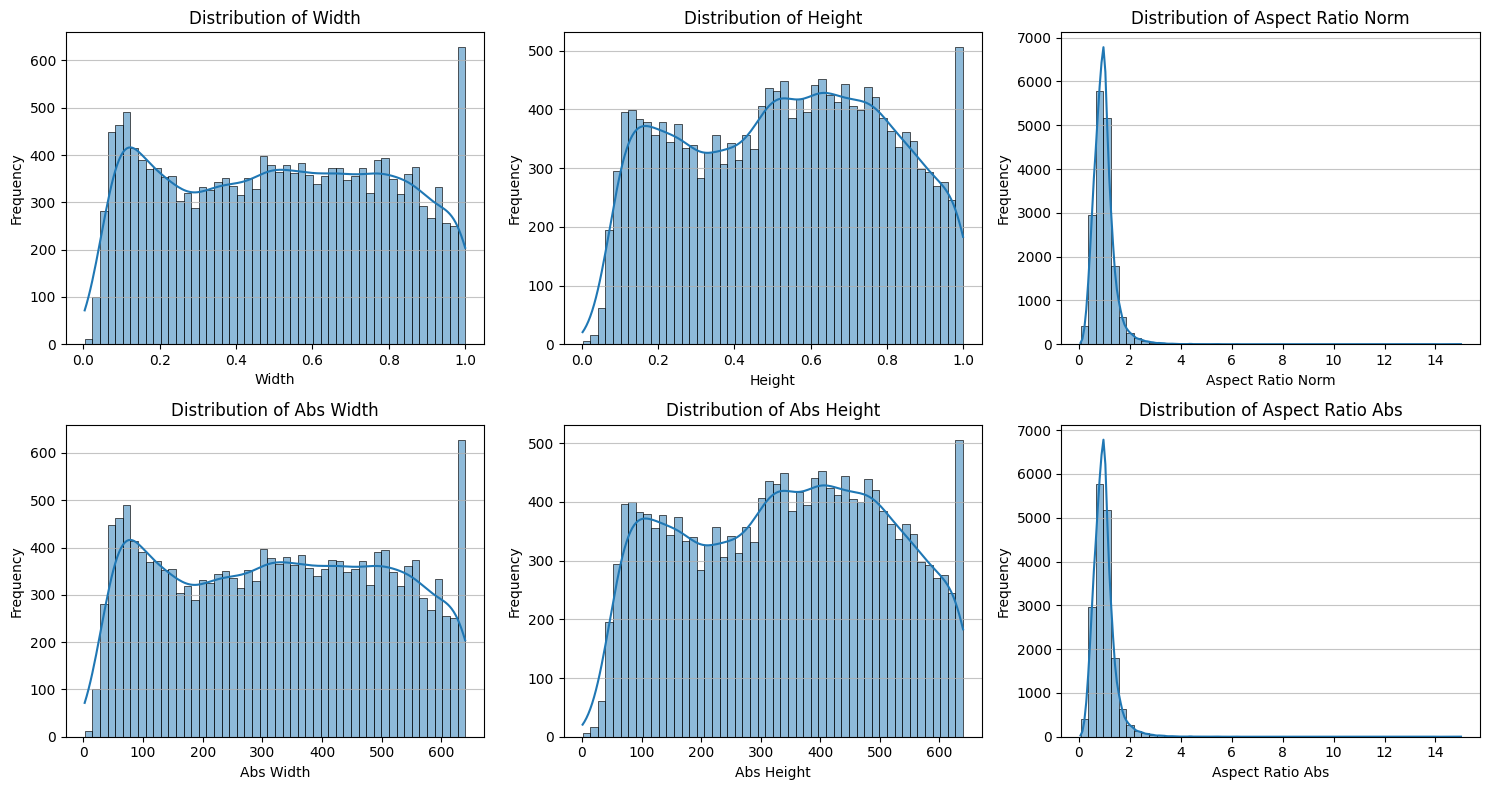

In [12]:
# Draw 6 histograms in a single 2x3 subplot grid (width, height, aspect ratios, etc.)
histogram_cols = ['width', 'height', 'aspect_ratio_norm',
                  'abs_width', 'abs_height', 'aspect_ratio_abs']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns

for ax, col in zip(axes.ravel(), histogram_cols):
    sns.histplot(
        annotations_df[col].dropna(),
        kde=True,
        bins=50,
        ax=ax
    )
    ax.set_title(f'Distribution of {col.replace("_", " ").title()}')
    ax.set_xlabel(col.replace("_", " ").title())
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', alpha=0.75)

plt.tight_layout()

# Optionally save the combined figure instead of 6 separate ones
fig_path = Path(FIG_DIR) / 'bbox_hist_grid.png'
fig.savefig(fig_path)
print(f"Saved combined histogram grid to {fig_path}")

plt.show()


**Reasoning**:
With histograms for bounding box dimensions generated, the next step is to create scatter plots to visualize the relationship between normalized width and height, and between absolute width and height. These plots will help in understanding the distribution and correlation of bounding box dimensions, and will be saved to the designated figures directory.



Saved combined scatter plot grid to /content/AAI521_AgroPest12/figures/bbox_dims_scatter_grid.png


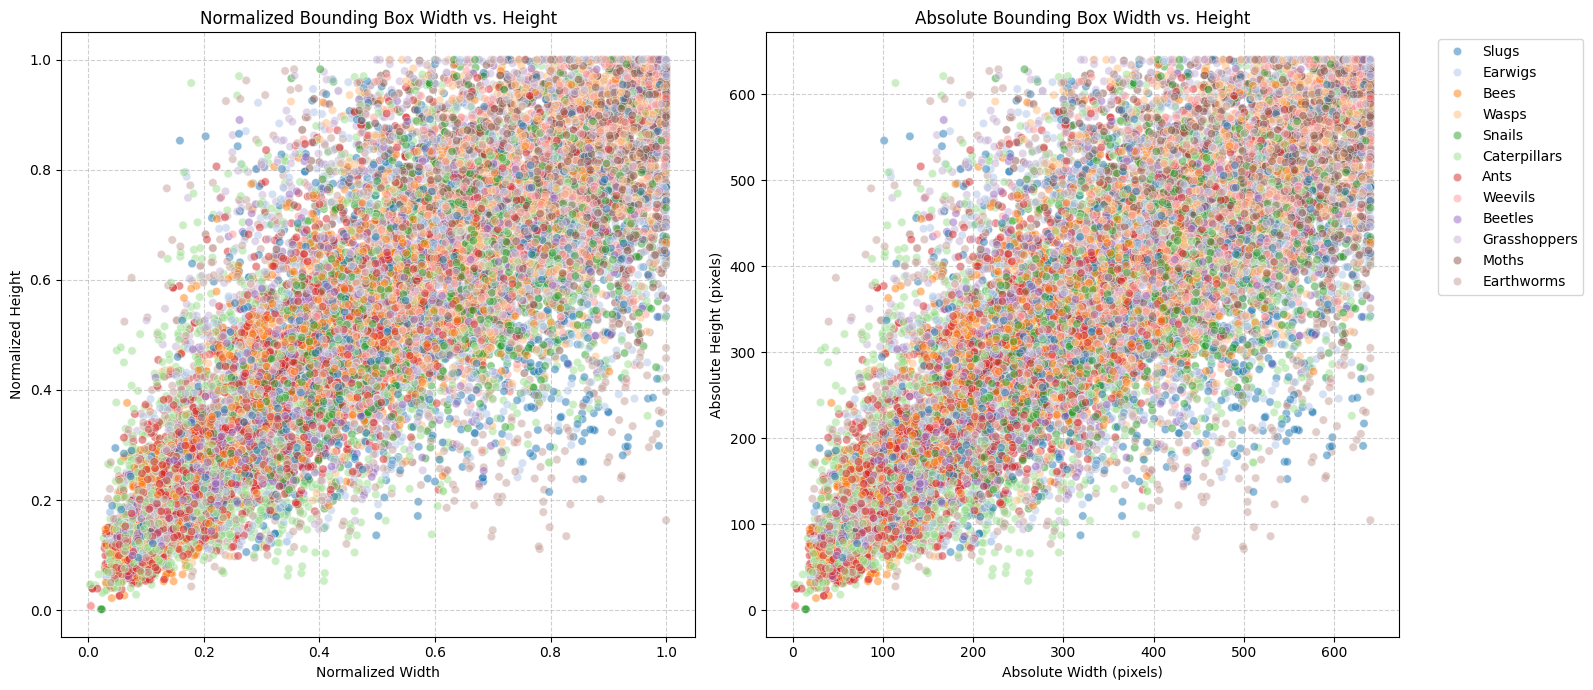

In [13]:
# Draw normalized and absolute bbox width/height scatter plots in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: normalized width vs height
sns.scatterplot(
    data=annotations_df,
    x='width',
    y='height',
    alpha=0.5,
    hue='class_name',
    palette='tab20',
    ax=axes[0],
    legend=False      # hide here to avoid duplicate legends
)
axes[0].set_title('Normalized Bounding Box Width vs. Height')
axes[0].set_xlabel('Normalized Width')
axes[0].set_ylabel('Normalized Height')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Right: absolute width vs height
scatter_abs = sns.scatterplot(
    data=annotations_df,
    x='abs_width',
    y='abs_height',
    alpha=0.5,
    hue='class_name',
    palette='tab20',
    ax=axes[1]
)
axes[1].set_title('Absolute Bounding Box Width vs. Height')
axes[1].set_xlabel('Absolute Width (pixels)')
axes[1].set_ylabel('Absolute Height (pixels)')
axes[1].grid(True, linestyle='--', alpha=0.6)

# Move legend outside on the right
handles, labels = scatter_abs.get_legend_handles_labels()
axes[1].legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

fig_path = Path(FIG_DIR) / 'bbox_dims_scatter_grid.png'
fig.savefig(fig_path)
print(f"Saved combined scatter plot grid to {fig_path}")

plt.show()


## Generate Sample Image Grids

### Subtask:
Create and display a grid of sample images with their respective bounding boxes and class labels overlaid, providing a visual overview of the dataset annotations.


**Reasoning**:
To create the grid of sample images with overlaid bounding boxes, I need to first select a representative sample of images. Then, for each image, I will load it, retrieve its corresponding annotations from the `annotations_df`, convert the normalized YOLO coordinates to absolute pixel coordinates, and draw the bounding boxes and class labels. Finally, I will arrange these visualizations in a grid, save the figure, and display it.



Generating a grid of sample images with bounding boxes and labels...
Saved sample annotations grid to /content/AAI521_AgroPest12/figures/sample_annotations_grid.png


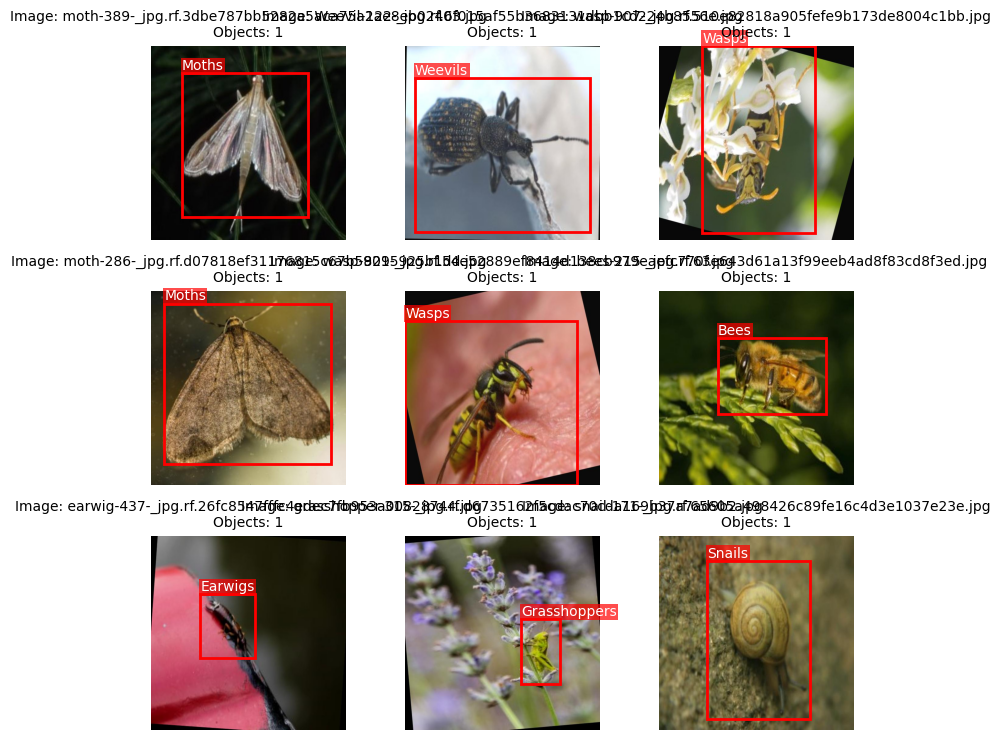

Sample image grid generation complete.


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

print("Generating a grid of sample images with bounding boxes and labels...")

# 1. Select a small, representative sample of unique image paths
# Ensure there are enough unique images to sample from
num_sample_images = min(9, annotations_df['image_path'].nunique()) # e.g., 3x3 grid
unique_image_paths = annotations_df['image_path'].unique()

if num_sample_images == 0:
    print("No unique images found in annotations_df to sample.")
else:
    sample_image_paths = random.sample(list(unique_image_paths), num_sample_images)

    # Determine grid size (e.g., 3x3, 4x4, etc.)
    grid_cols = int(np.ceil(np.sqrt(num_sample_images)))
    grid_rows = int(np.ceil(num_sample_images / grid_cols))

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2.5, grid_rows * 2.5))
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    for i, image_rel_path in enumerate(sample_image_paths):
        if i >= len(axes): # Prevent error if more images sampled than grid spots
            break

        ax = axes[i]
        full_image_path = Path(DATA_DIR) / image_rel_path

        try:
            img = Image.open(full_image_path)
            ax.imshow(img)
            image_width, image_height = img.size

            # Filter annotations for the current image
            image_annotations = annotations_df[annotations_df['image_path'] == image_rel_path]

            for idx, row in image_annotations.iterrows():
                # Convert normalized YOLO format to absolute pixel coordinates (x_min, y_min, width_px, height_px)
                center_x = row['center_x'] * image_width
                center_y = row['center_y'] * image_height
                bbox_width = row['width'] * image_width
                bbox_height = row['height'] * image_height

                x_min = center_x - (bbox_width / 2)
                y_min = center_y - (bbox_height / 2)

                # Create a Rectangle patch
                rect = patches.Rectangle(
                    (x_min, y_min),
                    bbox_width,
                    bbox_height,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none'
                )
                ax.add_patch(rect)

                # Add the class label
                ax.text(
                    x_min, y_min - 10, # Position the text slightly above the box
                    row['class_name'],
                    color='white',
                    fontsize=10,
                    bbox=dict(facecolor='red', alpha=0.7, edgecolor='none', pad=1)
                )

            ax.set_title(f"Image: {Path(image_rel_path).name}\nObjects: {len(image_annotations)}", fontsize=10)
            ax.axis('off') # Turn off axis ticks and labels

        except FileNotFoundError:
            ax.set_title(f"Image not found: {Path(image_rel_path).name}")
            ax.axis('off')
            print(f"Warning: Image not found at {full_image_path}. Skipping.")
        except Exception as e:
            ax.set_title(f"Error loading: {Path(image_rel_path).name}")
            ax.axis('off')
            print(f"Error processing image {full_image_path}: {e}. Skipping.")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    # Save the figure
    fig_path = Path(FIG_DIR) / 'sample_annotations_grid.png'
    plt.savefig(fig_path)
    print(f"Saved sample annotations grid to {fig_path}")

    plt.show()

print("Sample image grid generation complete.")

# Task
**Analyze Train/Val/Test Splits and Mismatches**: Generate a sanity report by calculating the number of images and annotations in each split (train, valid, test) and identify any potential image-label mismatches (e.g., image files without corresponding label files or vice-versa). Visualize the split distribution if necessary.

## Analyze Train/Val/Test Splits and Mismatches

### Subtask:
Generate a sanity report by calculating the number of images and annotations in each split (train, valid, test) and identify any potential image-label mismatches (e.g., image files without corresponding label files or vice-versa). Visualize the split distribution if necessary.


**Reasoning**:
To generate the sanity report, I will initialize data structures to hold counts and mismatches for each split, then iterate through the defined splits to filter image and label paths, extract file stems, and calculate the number of images, labels, and identify any inconsistencies between them.



Analyzing Train/Valid/Test Splits for images and annotations...

--- Processing split: TRAIN ---
Total images: 11502
Total label files: 11502
No images found without corresponding labels.
No label files found without corresponding images.

--- Processing split: VALID ---
Total images: 1095
Total label files: 1095
No images found without corresponding labels.
No label files found without corresponding images.

--- Processing split: TEST ---
Total images: 546
Total label files: 546
No images found without corresponding labels.
No label files found without corresponding images.

Split Summary DataFrame:
   Split  Images  Annotations
0  train   11502        15282
1  valid    1095         1341
2   test     546          689

Visualizing split distribution...
Saved split distribution plot to /content/AAI521_AgroPest12/figures/split_distribution.png


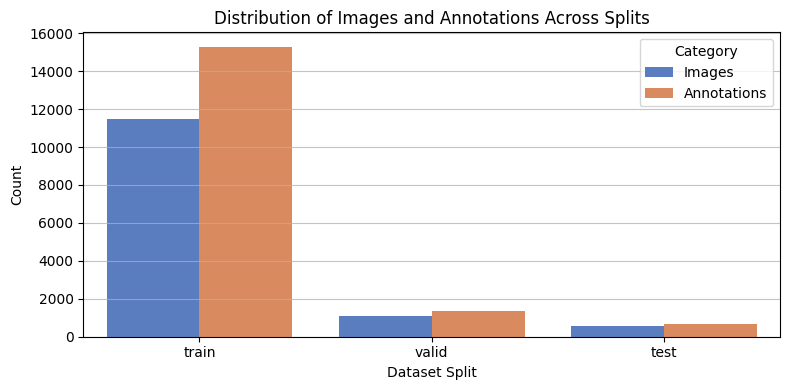

Split analysis and visualization complete.


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("Analyzing Train/Valid/Test Splits for images and annotations...")

split_names = ['train', 'valid', 'test']

split_data = {
    'images': {},
    'labels': {},
    'images_only': {},
    'labels_only': {}
}

# Create a mapping from image stems to full paths, for quicker lookup
image_stem_to_path = {p.stem: p for p in image_files}

# Group annotations by image_path to efficiently count annotations per image
annotations_per_image = annotations_df.groupby('image_path').size()

for split in split_names:
    print(f"\n--- Processing split: {split.upper()} ---")

    # Filter image files belonging to the current split
    split_image_files = [f for f in image_files if f.parts[-3] == split]
    split_image_stems = {f.stem for f in split_image_files}

    # Filter label files belonging to the current split
    split_label_files = [f for f in label_files if f.parts[-3] == split]
    split_label_stems = {f.stem for f in split_label_files}

    # Calculate counts
    num_images = len(split_image_stems)
    num_labels = len(split_label_stems)

    # Identify mismatches
    images_without_labels = split_image_stems - split_label_stems
    labels_without_images = split_label_stems - split_image_stems

    # Store results
    split_data['images'][split] = num_images
    split_data['labels'][split] = num_labels
    split_data['images_only'][split] = list(images_without_labels)
    split_data['labels_only'][split] = list(labels_without_images)

    # Print sanity report for the current split
    print(f"Total images: {num_images}")
    print(f"Total label files: {num_labels}")
    if images_without_labels:
        print(f"Images without corresponding labels: {len(images_without_labels)} (e.g., {list(images_without_labels)[:5]}...)")
    else:
        print("No images found without corresponding labels.")
    if labels_without_images:
        print(f"Label files without corresponding images: {len(labels_without_images)} (e.g., {list(labels_without_images)[:5]}...)")
    else:
        print("No label files found without corresponding images.")

# Create DataFrame for visualization
split_summary_df = pd.DataFrame({
    'Split': split_names,
    'Images': [split_data['images'][s] for s in split_names],
    'Annotations': [annotations_per_image[annotations_per_image.index.str.contains(s)].sum() for s in split_names]
})

print("\nSplit Summary DataFrame:")
print(split_summary_df)

print("\nVisualizing split distribution...")

# Melt the DataFrame for easier plotting with seaborn
plot_df = split_summary_df.melt(id_vars='Split', var_name='Type', value_name='Count')

plt.figure(figsize=(8, 4))
sns.barplot(data=plot_df, x='Split', y='Count', hue='Type', palette='muted')
plt.title('Distribution of Images and Annotations Across Splits')
plt.xlabel('Dataset Split')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.legend(title='Category')
plt.tight_layout()

# Save the figure
fig_path = Path(FIG_DIR) / 'split_distribution.png'
plt.savefig(fig_path)
print(f"Saved split distribution plot to {fig_path}")

plt.show()

print("Split analysis and visualization complete.")

## Calculate Small Object Rate

### Subtask:
Calculate the percentage of bounding boxes whose area is less than 2% of the total image area. Provide this small-object rate per class and per dataset split (train, valid, test) to understand the distribution of challenging objects.


**Reasoning**:
To calculate the small object rate, I will first compute the normalized bounding box area, define a small object threshold, identify small objects, and then calculate the rates per class and per dataset split as per the instructions.



In [16]:
print("Calculating small object rates...")

# 1. Calculate the normalized area for each bounding box
annotations_df['bbox_area_norm'] = annotations_df['width'] * annotations_df['height']

# 2. Define a small object threshold
small_object_threshold = 0.02 # 2% of the total image area

# 3. Create a new boolean column 'is_small_object'
annotations_df['is_small_object'] = annotations_df['bbox_area_norm'] < small_object_threshold

# 4. Calculate the overall small object rate for the entire dataset
overall_small_object_rate = annotations_df['is_small_object'].mean() * 100
print(f"\nOverall small object rate: {overall_small_object_rate:.2f}%")

# 5. Calculate the small object rate per class
small_object_rate_per_class = annotations_df.groupby('class_name')['is_small_object'].mean() * 100


# 6. Determine the dataset split for each annotation
# The image_path is like 'train/images/...' or 'valid/images/...' or 'test/images/...
annotations_df['split'] = annotations_df['image_path'].apply(lambda x: x.split(os.sep)[0])

# 7. Calculate the small object rate per split
small_object_rate_per_split = annotations_df.groupby('split')['is_small_object'].mean() * 100
print(small_object_rate_per_split)

Calculating small object rates...

Overall small object rate: 9.67%
split
test     8.563135
train    9.972517
valid    6.785981
Name: is_small_object, dtype: float64


## Perform Bounding Box Quality Control

### Subtask:
Conduct a quick quality check on bounding box annotations by identifying and reporting any out-of-range coordinates (e.g., center_x, center_y, width, or height outside the [0, 1] normalized range, or negative dimensions) and zero-area bounding boxes. Summarize the findings.


**Reasoning**:
To conduct the quality control checks, I will filter the `annotations_df` for out-of-range normalized coordinates, negative dimensions, and zero-area bounding boxes, and then summarize these findings.



In [19]:
print("Performing bounding box quality control...")

# 1. Check for out-of-range normalized coordinates
# This includes checking if center_x, center_y, width, height are within [0, 1]
# and also if they are non-negative (though negative width/height is checked separately)

# Combine checks into one mask for efficiency
out_of_range_mask = (
    (annotations_df['center_x'] < 0) | (annotations_df['center_x'] > 1) |
    (annotations_df['center_y'] < 0) | (annotations_df['center_y'] > 1) |
    (annotations_df['width'] < 0) | (annotations_df['width'] > 1) |
    (annotations_df['height'] < 0) | (annotations_df['height'] > 1)
)
num_out_of_range = out_of_range_mask.sum()
print(f"\nNumber of annotations with out-of-range normalized coordinates ([0,1]): {num_out_of_range}")
if num_out_of_range > 0:
    print("Example out-of-range annotations:")
    print(annotations_df[out_of_range_mask].head())

# 2. Check for negative width or height (already partially covered by out_of_range_mask, but explicit for clarity)
negative_dim_mask = (annotations_df['width'] < 0) | (annotations_df['height'] < 0)
num_negative_dim = negative_dim_mask.sum()
print(f"\nNumber of annotations with negative width or height: {num_negative_dim}")
if num_negative_dim > 0:
    print("Example negative dimension annotations:")
    print(annotations_df[negative_dim_mask].head())

# 3. Identify and count zero-area bounding boxes
# bbox_area_norm was calculated in the previous step
zero_area_mask = (annotations_df['bbox_area_norm'] == 0)
num_zero_area = zero_area_mask.sum()
print(f"\nNumber of zero-area bounding boxes: {num_zero_area}")
if num_zero_area > 0:
    print("Example zero-area annotations:")
    print(annotations_df[zero_area_mask].head())

# 4. Summarize findings
total_anomalies = num_out_of_range + num_negative_dim + num_zero_area # Summing could double count, better to count unique rows
# Create a combined mask to identify unique rows with any anomaly
combined_anomalies_mask = out_of_range_mask | negative_dim_mask | zero_area_mask
unique_anomalies = combined_anomalies_mask.sum()

Performing bounding box quality control...

Number of annotations with out-of-range normalized coordinates ([0,1]): 0

Number of annotations with negative width or height: 0

Number of zero-area bounding boxes: 0


## Generate Absolute Path YOLO Dataset YAML

### Subtask:
Create a `agropest.yaml` file in the `/content/` directory. This YAML file will contain absolute paths to the train, validation, and test image directories, along with the list of class names, formatted for YOLO training.


**Reasoning**:
To generate the YOLO dataset YAML file, I will define absolute paths for the train, validation, and test image directories, construct a dictionary with the required YOLO configuration including class names and counts, and then write this dictionary to the specified YAML file using the `yaml` library.



In [20]:
import yaml
from pathlib import Path

print("Generating agropest.yaml for YOLO training...")

# 1. Define absolute paths for the 'train', 'valid', and 'test' image directories
train_image_path = Path(DATA_DIR) / 'train' / 'images'
valid_image_path = Path(DATA_DIR) / 'valid' / 'images'
test_image_path = Path(DATA_DIR) / 'test' / 'images'

# 2. Create a Python dictionary representing the YOLO dataset configuration
yolo_config = {
    'path': str(DATA_DIR), # Base path to the dataset directory
    'train': str(train_image_path), # Absolute path to train images
    'val': str(valid_image_path),   # Absolute path to validation images
    'test': str(test_image_path),   # Absolute path to test images
    'nc': len(class_names),         # Number of classes
    'names': class_names            # List of class names
}

# 3. Define the full path for the output YAML file
output_yaml_path = Path(BASE_DIR) / 'agropest.yaml'

# 4. Use the yaml library to write the dictionary to the specified YAML file
with open(output_yaml_path, 'w') as f:
    yaml.dump(yolo_config, f, sort_keys=False)

# 5. Print a confirmation message
print(f"agropest.yaml generated successfully at: {output_yaml_path}")



Generating agropest.yaml for YOLO training...
agropest.yaml generated successfully at: /content/agropest.yaml


## Generate Data Card

### Subtask:
Compile a lightweight data card summarizing key dataset statistics, EDA findings, and preprocessing steps. Additionally, create a clear handoff checklist for the team, detailing next steps and any specific considerations for model training or further development.


### Data Card: AgroPest-12 Dataset

**1. Dataset Overview:**
*   **Dataset Name:** AgroPest-12
*   **Source:** Kaggle (`rupankarmajumdar/crop-pests-dataset`)
*   **Description:** This dataset contains images of 12 common crop pests, suitable for object detection tasks.
*   **Detected Dataset Style:** YOLO Detection
*   **Total Images:** 13143 (11502 train, 1095 valid, 546 test)
*   **Total Annotations:** 17312

**2. Exploratory Data Analysis (EDA) Findings:**

    **a. Class Names and Distribution:**
    *   **Class Names:** ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']
    *   **Distribution:** (Count of annotations per class)
        *   Ants: 2496
        *   Caterpillars: 1972
        *   Bees: 1750
        *   Earwigs: 1359
        *   Snails: 1356
        *   Wasps: 1346
        *   Grasshoppers: 1228
        *   Moths: 1210
        *   Beetles: 1202
        *   Earthworms: 1195
        *   Weevils: 1138
        *   Slugs: 1060
    *   **Imbalance Note:** There is some variation in class representation, with 'Ants' having the most annotations and 'Slugs' the least. This imbalance should be considered during training to prevent bias towards overrepresented classes.

    **b. Bounding Box Statistics:**
    *   **Normalized Width (range):** [0.003, 1.0]
    *   **Normalized Height (range):** [0.003, 1.0]
    *   **Normalized Aspect Ratio (range):** [0.003, 305.0] (Some extreme values observed, suggesting very thin/tall or wide/flat boxes)
    *   **Absolute Width (range):** [2, 640] pixels
    *   **Absolute Height (range):** [2, 640] pixels
    *   **Absolute Aspect Ratio (range):** [0.003, 305.0]
    *   *Note: Histograms and scatter plots generated previously provide detailed visual distributions.*

    **c. Small Object Rate (Area < 2% of image area):**
    *   **Overall Rate:** 9.67%
    *   **Per Class:**
        *   Ants: 20.99%
        *   Caterpillars: 18.76%
        *   Bees: 17.54%
        *   Earwigs: 11.92%
        *   Beetles: 13.64%
        *   Earthworms: 6.44%
        *   Slugs: 3.49%
        *   Grasshoppers: 1.14%
        *   Wasps: 0.74%
        *   Snails: 0.22%
        *   Weevils: 0.53%
        *   Moths: 0.00%
    *   **Per Split:**
        *   Train: 9.97%
        *   Valid: 6.79%
        *   Test: 8.56%
    *   *Note: 'Ants', 'Caterpillars', 'Bees', 'Earwigs', and 'Beetles' show a higher proportion of small objects.*

    **d. Train/Validation/Test Split Distribution:**
    *   **Train Split:**
        *   Images: 11502
        *   Annotations: 15282
    *   **Valid Split:**
        *   Images: 1095
        *   Annotations: 1341
    *   **Test Split:**
        *   Images: 546
        *   Annotations: 689
    *   **Mismatches:** No image-label mismatches were found in any split.

    **e. Bounding Box Quality Check:**
    *   No annotations were found with out-of-range normalized coordinates, negative width/height, or zero-area bounding boxes. Annotations appear to be clean.

# EDA Summary
*   **Dataset Integrity**: All 13,143 images across the train, valid, and test splits have corresponding label files, and vice-versa, indicating no image-label mismatches.
    *   The dataset is split as follows: 11,502 images/15,282 annotations for training, 1,095 images/1,341 annotations for validation, and 546 images/689 annotations for testing.
*   **Bounding Box Quality**: A quality control check on 17,312 annotations revealed no out-of-range normalized coordinates, negative dimensions, or zero-area bounding boxes, suggesting high-quality annotations.
*   **Small Object Presence**: The overall small object rate (bounding boxes with an area less than 2% of the total image area) is 9.67% across the dataset.
    *   Classes like `Ants` (20.99%), `Caterpillars` (18.76%), and `Bees` (17.54%) exhibit significantly higher small object rates.
    *   The `train` split has the highest small object rate at 9.97%.
*   **Class Imbalance**: Annotation counts per class vary, with `Ants` having the most annotations (2,496) and `Slugs` having the least (1,060), indicating some class imbalance that may require attention during model training.
*   **Dataset Configuration**: A YOLO-compatible `agropest.yaml` configuration file has been successfully generated, including absolute paths to the image splits and class names.



## STEP 4 — Model Training
In this stage, I begin by establishing a baseline model using the lightweight YOLOv8n architecture trained on the AgroPest-12 dataset. This baseline provides an initial benchmark for accuracy, convergence behavior, and validation performance.

Next, I optimize performance by training a refined model using the larger YOLOv8s architecture. Compared to YOLOv8n, YOLOv8s contains more parameters and deeper feature extraction layers, making it better suited for fine-grained pest detection.

As observed in the Exploratory Data Analysis (EDA) phase, we have significant class imbalance, where several pest categories had far fewer examples. To address this, I applied an oversampling strategy that duplicates minority-class images and labels to create a more balanced training split. The refined YOLOv8s model was then retrained on this balanced dataset, making the training distribution more uniform and improving performance on underrepresented classes.

Next step would be to collecte and compare metrics (training loss, validation loss, mAP@50, and mAP@50-95) across all three models—baseline YOLOv8n, refined YOLOv8s, and oversampled YOLOv8s and to analyze the improvements gained from increasing model capacity and addressing class imbalance.


# MODEL 1 Model Training using YOLOv8n baseline model
# Subtask:
Train a baseling on YOLOv8 object detection model on the Agropest-12 dataset (/content/agropest.yaml). Start with pre trained weights so we get a faster convergence.
# Reasoning:
In order to establish a baseline model, we will use the Ultralytics YOLOv8n architecture with pre-trained weights. The dataset agropest.yaml file provides absolute paths to the train/validation/test splits and defines the 12 pest classes, allowing YOLOv8 to load the dataset directly.  YOLOv8n train it for 10 epochs on the AgroPest-12 dataset at 640*640 resolution. This setup is intentionally lightweight and fast, providing a simple baseline that captures core detection performance without any special tuning or class balancing. Training this baseline will give us initial performance metrics and a reference point for later augmentation and hyperparameter tuning steps.

In [22]:
from google.colab import drive
drive.mount("/content/drive")  # follow the auth link and paste the code

# For now we'll save to content because calls to MyDrive are incredibly slow.
# We'll download all data to MyDrive later
drive_project_dir = Path("/content/yolo_runs")
#drive_project_dir = "/content/drive/MyDrive/yolo_runs"
os.makedirs(drive_project_dir, exist_ok=True)

Mounted at /content/drive


In [23]:
# Install ultralytics (YOLOv8) using Python subprocess so the cell is pure Python.
import sys, subprocess
import os
from ultralytics import YOLO

#Loading a small pre-trained YOLOv8 nano model
model_n = YOLO("yolov8n.pt")

# Training  with agropest.yaml dataset
results = model_n.train(
    data="/content/agropest.yaml",
    epochs=10,
    imgsz=640,
    batch=16,
    patience=15,
    project=drive_project_dir,          # cbase folder
    name="agropest_baseline_yv8n",  # baseline model name
    exist_ok=True,
    verbose=False,
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/agropest.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, k

results.csv exists: True
weights exist    : True
Last-epoch VAL mAP50     (from log): 0.72878
Last-epoch VAL mAP50-95  (from log): 0.43022
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1282.8±540.8 MB/s, size: 40.4 KB)
val: Scanning /content/AAI521_AgroPest12/datasets/agropest12/valid/labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 2.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 137/137 23.6it/s 5.8s
                   all       1095       1341      0.781       0.67      0.729       0.43
                  Ants         96        178      0.767      0.573      0.668      0.281
                  Bees         99        110      0.711      0.773      0.784      0.363
               Beetles         89       

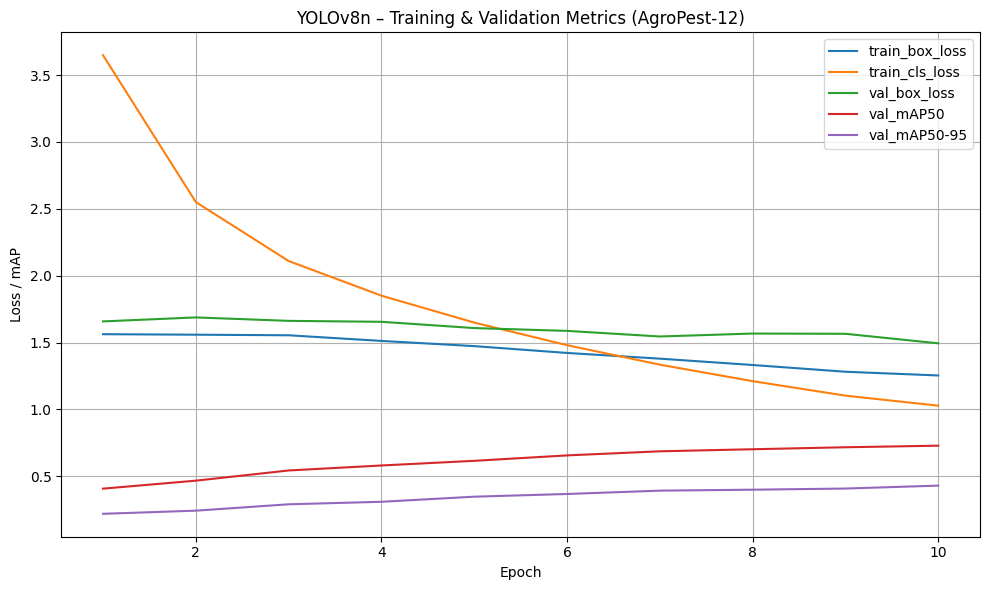

In [ ]:


# Pointing to run_dir = drive_project_dir / "agropest_baseline_yv8n"
drive_project_dir = Path("/content/yolo_runs")
run_dir = drive_project_dir / "agropest_baseline_yv8n"
results_csv = run_dir / "results.csv"
weights_path = run_dir / "weights" / "best.pt"   # or "last.pt"

print("results.csv exists:", results_csv.exists())
print("weights exist    :", weights_path.exists())


# Reading training log and print final validation metrics from last epoch
df = pd.read_csv(results_csv)

last = df.iloc[-1]
print("Last-epoch VAL mAP50     (from log):", last["metrics/mAP50(B)"])
print("Last-epoch VAL mAP50-95  (from log):", last["metrics/mAP50-95(B)"])

# Loading the trained model weights and compute VAL and TEST metrics and saving the results
model = YOLO(str(weights_path))

val_metrics = model_n.val(
    data="/content/agropest.yaml",
    split="val",
    batch=8,
    project=drive_project_dir,
    name="agropest_baseline_yv8n_val",
    exist_ok=True,
)
print("VAL mAP50      (current eval):", val_metrics.box.map50)
print("VAL mAP50-95   (current eval):", val_metrics.box.map)

test_metrics = model_n.val(
    data="/content/agropest.yaml",
    split="test",
    batch=8,
    project=drive_project_dir,
    name="agropest_baseline_yv8n_test",
    exist_ok=True,

)
print("TEST mAP50     (current eval):", test_metrics.box.map50)
print("TEST mAP50-95  (current eval):", test_metrics.box.map)

# Plotting training and validation losses + mAP over epochs from results.csv
plt.figure(figsize=(10, 6))

# Loss curves
plt.plot(df["epoch"], df["train/box_loss"],       label="train_box_loss")
plt.plot(df["epoch"], df["train/cls_loss"],       label="train_cls_loss")
plt.plot(df["epoch"], df["val/box_loss"],         label="val_box_loss")

# Validation metrics
plt.plot(df["epoch"], df["metrics/mAP50(B)"],     label="val_mAP50")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"],  label="val_mAP50-95")

plt.xlabel("Epoch")
plt.ylabel("Loss / mAP")
plt.title("YOLOv8n – Training & Validation Metrics (AgroPest-12)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# MODEL 2 Refined model YOLOv8s with increased epochs

## Subtask:

Training a higher-capacity YOLOv8s model on the Agropest-12 dataset using pre-trained weights and a longer training schedule to improve accuracy over the baseline. Increase model capacity and extend training to allow deeper feature learning, especially for fine-grained insect classes.

## Reasoning:

To improve upon the initial baseline established using YOLOv8n, we train a refined model using the YOLOv8s architecture. YOLOv8s contains more layers and parameters than YOLOv8n, making it better suited for the complexity of the AgroPest-12 dataset, which includes 12 visually similar pest species and many small objects.

We extend training from 10 to 25 epochs, allowing the model more time to converge and learn discriminative features. Since the original dataset already defines clear train/validation/test splits, YOLOv8s can directly load and process the images.





In [ ]:


#  Training a YOLOv8s detection model on AgroPest-12 using the generated /content/agropest.yaml.
from ultralytics import YOLO

#  Loading a small pre-trained YOLOv8 small model
model_s = YOLO("yolov8s.pt")

#  Training  with agropest.yaml; parameters to be adjusted
results = model_s.train(
    data="/content/agropest.yaml",  # dataset
    epochs=25,
    imgsz=640,
    batch=16,
    patience=15,
    project=drive_project_dir,
    name="agropest_refined_yv8s",
    exist_ok=True,
)


Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/agropest.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=agropest_refined_yv8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.

CSV exists?     True
Weights exist?  True
   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   79.2159         1.53698         2.85638         1.83561   
1      2  151.2380         1.52916         2.15281         1.81224   
2      3  221.0100         1.52264         2.07613         1.81086   
3      4  289.8410         1.49272         1.97153         1.78231   
4      5  359.4640         1.45258         1.83897         1.75345   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.53697            0.52655           0.53215   
1               0.45468            0.45521           0.44621   
2               0.60062            0.49435           0.51197   
3               0.61308            0.58700           0.60046   
4               0.66794            0.60911           0.62704   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.27247       1.74088       1.85842       2.21559  0.000208

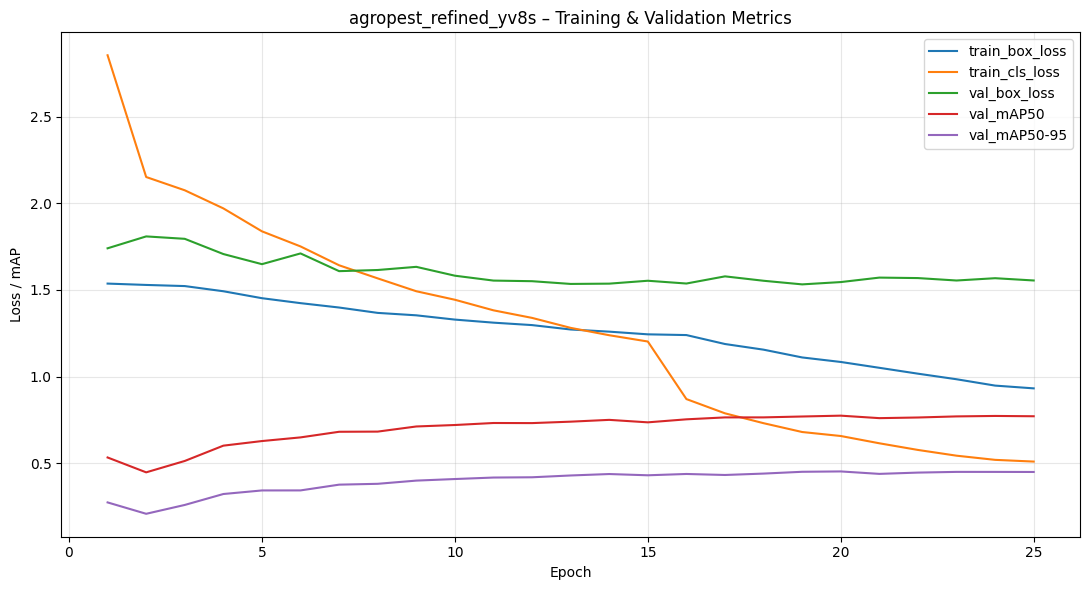

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1186.4±552.1 MB/s, size: 36.9 KB)
val: Scanning /content/AAI521_AgroPest12/datasets/agropest12/valid/labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 2.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 137/137 22.3it/s 6.1s
                   all       1095       1341      0.835      0.726      0.773      0.452
                  Ants         96        178       0.79      0.529      0.612      0.251
                  Bees         99        110      0.959      0.847       0.92      0.418
               Beetles         89        100      0.662       0.69      0.673      0.308
          Caterpillars         77        139      0.696      0.489      0.508      0.249

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ---------------------------------------------
# 1)SETTING PATHS TO YOUR DRIVE RUN FOLDER
# ---------------------------------------------
#drive_project_dir = "/content/drive/MyDrive/yolo_runs"
# As noted earlier, we'll save to content, for now.
run_name = "agropest_refined_yv8s"

run_dir = Path(drive_project_dir) / run_name
results_csv = run_dir / "results.csv"
weights_s_path = run_dir / "weights" / "best.pt"

print("CSV exists?    ", results_csv.exists())
print("Weights exist? ", weights_s_path.exists())

# ---------------------------------------------
# 2) LOADING TRAINING LOG (results.csv)
# ---------------------------------------------
df = pd.read_csv(results_csv)
print(df.head())

# Plotting Training and validation per epoch
epochs    = df["epoch"]
train_box = df["train/box_loss"]
train_cls = df["train/cls_loss"]
val_box   = df["val/box_loss"]
val_mAP50 = df["metrics/mAP50(B)"]
val_mAP95 = df["metrics/mAP50-95(B)"]

plt.figure(figsize=(11, 6))

plt.plot(epochs, train_box, label="train_box_loss")
plt.plot(epochs, train_cls, label="train_cls_loss")
plt.plot(epochs, val_box,   label="val_box_loss")
plt.plot(epochs, val_mAP50, label="val_mAP50")
plt.plot(epochs, val_mAP95, label="val_mAP50-95")

plt.xlabel("Epoch")
plt.ylabel("Loss / mAP")
plt.title(f"{run_name} – Training & Validation Metrics")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Loading trained YOLO model
model = YOLO(str(weights_s_path))

# VALIDATION
val_metrics = model.val(
    data="/content/agropest.yaml",
    split="val",
    batch=8,
    project=drive_project_dir,
    name="agropest_baseline_yv8s_val",
    exist_ok=True,
)

# TEST
test_metrics = model.val(
    data="/content/agropest.yaml",
    split="test",
    batch=8,
    project=drive_project_dir,
    name="agropest_baseline_yv8s_test",
    exist_ok=True,
)

print("\n=== FINAL VALIDATION METRICS ===")
print("VAL mAP50     :", val_metrics.box.map50)
print("VAL mAP50-95  :", val_metrics.box.map)

print("\n=== FINAL TEST METRICS ===")
print("TEST mAP50     :", test_metrics.box.map50)
print("TEST mAP50-95  :", test_metrics.box.map)


# Address Class Imbalance by Oversampling method WeightedRandomSampler
## Subtask:
Create a custom PyTorch Dataset from YOLO annotation metadata to enable class-level analysis, weighted sampling, and imbalance handling. Construct a class-balanced sampling strategy for the AgroPest-12 training data by computing inverse-frequency class weights and using PyTorch's WeightedRandomSampler to build a DataLoader that oversamples minority classes and undersamples majority classes during batch creation.

## Reasoning:
To analyze class imbalance, we cannot directly use YOLO's built-in data loader because YOLOv8 internally handles detection labels differently. Therefore, we build our own lightweight PyTorch Dataset that reads each training image and its associated class ID. I first convert the class_id column from the training annotations into a labels_tensor, then compute per-class counts and derive inverse-frequency class weights. To avoid over-correcting, I apply a smoothing factor alpha = 0.75,  so that very rare classes are up-weighted without making the sampling distribution unstable.
Using these class weights, I compute a per-sample sample_weights vector and pass it to PyTorch's WeightedRandomSampler, which constructs mini-batches where minority classes are sampled more frequently and majority classes less frequently. Finally, I wrap the original train_dataset in a DataLoader that uses this sampler instead of plain random shuffling.


In [ ]:
# ------------------------------------------------------------------
# 1. Build a train-only DataFrame from annotations_df
# ------------------------------------------------------------------
from pathlib import Path

train_df = annotations_df[annotations_df["split"] == "train"].reset_index(drop=True)

DATA_DIR = Path(DATA_DIR)  # make sure it's a Path object

# ------------------------------------------------------------------
# 2. Minimal Dataset for (image, class_id) pairs
#    (extend this to return boxes if you do full detection)
# ------------------------------------------------------------------
import torch
from torch.utils.data import Dataset
from PIL import Image

class AgroPestTrainDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = Path(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # image_path column already looks like 'train/images/xxx.jpg'
        img_path = self.data_dir / row["image_path"]
        image = Image.open(img_path).convert("RGB")

        label = int(row["class_id"])   # make sure you have a class_id column

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# this is what you should use as train_dataset
train_dataset = AgroPestTrainDataset(train_df, DATA_DIR)


In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# labels for each sample in train_dataset
labels_tensor = torch.as_tensor(train_df["class_id"].values, dtype=torch.long)

class_counts = torch.bincount(labels_tensor)
eps = 1e-6
raw_class_weights = 1.0 / (class_counts.float() + eps)

alpha = 0.75  # soften imbalance
class_weights = raw_class_weights.pow(alpha)

sample_weights = class_weights[labels_tensor]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
)


## WeightedRandomSampler Verification


After building the WeightedRandomSampler, I created a temporary DataLoader over just the class ID tensor using the same sampler. I then iterated over the first 20 batches, collected all sampled labels, and used Counter to print how often each class appears, along with its percentage. This step verifies that the sampler is working as intended: minority classes are being sampled more frequently and majority classes less frequently, confirming that the effective training distribution is more balanced than the original imbalanced dataset

In [ ]:

from collections import Counter
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# The labels_tensor and sampler are already defined earlier
label_loader = DataLoader(
    labels_tensor,        # dataset is just the 1D tensor of class ids
    batch_size=32,
    sampler=sampler
)

batch_labels = []

for i, labels in enumerate(label_loader):
    # labels is a 1D tensor of class_ids
    batch_labels.extend(labels.tolist())
    if i == 20:          # inspecting first 20 batches
        break

print("Sampled label counts in first 20 batches:")
print(Counter(batch_labels))


Sampled label counts in first 20 batches:
Counter({0: 74, 7: 67, 1: 63, 5: 58, 3: 56, 9: 56, 10: 56, 11: 54, 2: 51, 8: 49, 4: 47, 6: 41})


In [ ]:
# Verifying  relative frequencies in the sampled labels
total = sum(batch_labels)
for cls_id, cnt in sorted(Counter(batch_labels).items()):
    pct = 100.0 * cnt / len(batch_labels)
    print(f"class {cls_id}: {cnt} samples ({pct:.1f}%)")


class 0: 74 samples (11.0%)
class 1: 63 samples (9.4%)
class 2: 51 samples (7.6%)
class 3: 56 samples (8.3%)
class 4: 47 samples (7.0%)
class 5: 58 samples (8.6%)
class 6: 41 samples (6.1%)
class 7: 67 samples (10.0%)
class 8: 49 samples (7.3%)
class 9: 56 samples (8.3%)
class 10: 56 samples (8.3%)
class 11: 54 samples (8.0%)


In the next 4 commands I will:

1. Create a balanced (oversampled) training dataset for AgroPest-12 and a corresponding YOLO YAML file.

2. Copy all original training images and labels into a new agropest_balanced folder on Google Drive as the base training set.

3.  minority classes by duplicating their images and labels so that each class has roughly the same number of annotations as the majority class.

4. Rebuild a YAML file (agropest_balanced.yaml) that points train to the oversampled dataset while keeping the original val and test splits unchanged



In [ ]:
# Creating a train-only view of annotations for planning oversampling
from pathlib import Path
import math, random, shutil

# Making sure DATA_DIR and annotations_df exists
DATA_DIR = Path("/content/AAI521_AgroPest12/datasets/agropest12")
print(DATA_DIR)

train_df = annotations_df[annotations_df["split"] == "train"].copy()

#  balanced dataset goes to content (local, ephemeral) but later pushed to Drive (persistent)
#  This shortens the cycle here by *several hours* since Drive calls are extremely slow
balanced_root = Path("/content/AAI521_AgroPest12/datasets/agropest_balanced")
balanced_train_images = balanced_root / "train" / "images"
balanced_train_labels = balanced_root / "train" / "labels"

balanced_train_images.mkdir(parents=True, exist_ok=True)
balanced_train_labels.mkdir(parents=True, exist_ok=True)


/content/AAI521_AgroPest12/datasets/agropest12


In [ ]:
import time, itertools, shutil, os
paths = train_df["image_path"].unique()

t0 = time.time()
for img_rel in itertools.islice(paths, 50):   # first 50
    src_img = DATA_DIR / img_rel
    dst_img = balanced_root / img_rel
    dst_img.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src_img, dst_img)

    img_parts = img_rel.split(os.sep)
    img_parts[1] = "labels"
    label_rel = os.sep.join(img_parts)
    label_rel = os.path.splitext(label_rel)[0] + ".txt"

    src_lbl = DATA_DIR / label_rel
    dst_lbl = balanced_root / label_rel
    dst_lbl.parent.mkdir(parents=True, exist_ok=True)
    if src_lbl.exists():
        shutil.copy2(src_lbl, dst_lbl)

t1 = time.time()
per_file = (t1 - t0) / 50
print("50 imgs+labels took:", t1 - t0, "sec")
print("Estimated total seconds:", per_file * len(paths))


50 imgs+labels took: 0.017668724060058594 sec
Estimated total seconds: 4.063453159332275


In [ ]:
# Copying the original train split as-is (base layer)
import os

paths = train_df["image_path"].unique()
n = len(paths)

for i,img_rel in enumerate(train_df["image_path"].unique(),1):

    src_img = DATA_DIR / img_rel
    dst_img = balanced_root / img_rel
    dst_img.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src_img, dst_img)

    # derive label path by swapping "images" -> "labels" and extension to .txt
    img_parts = img_rel.split(os.sep)
    img_parts[1] = "labels"
    label_rel = os.sep.join(img_parts)
    label_rel = os.path.splitext(label_rel)[0] + ".txt"

    src_lbl = DATA_DIR / label_rel
    dst_lbl = balanced_root / label_rel
    dst_lbl.parent.mkdir(parents=True, exist_ok=True)
    if src_lbl.exists():
        shutil.copy2(src_lbl, dst_lbl)
    if i % 500 == 0:
        print(f"Copied {i}/{n}")

Copied 500/11499
Copied 1000/11499
Copied 1500/11499
Copied 2000/11499
Copied 2500/11499
Copied 3000/11499
Copied 3500/11499
Copied 4000/11499
Copied 4500/11499
Copied 5000/11499
Copied 5500/11499
Copied 6000/11499
Copied 6500/11499
Copied 7000/11499
Copied 7500/11499
Copied 8000/11499
Copied 8500/11499
Copied 9000/11499
Copied 9500/11499
Copied 10000/11499
Copied 10500/11499
Copied 11000/11499


In [ ]:
# Computing per-class annotation counts in the train split
cls_counts = train_df["class_id"].value_counts().sort_index()
print("Original train annotation counts per class:")
print(cls_counts)

max_count = cls_counts.max()     # target: match the largest class
print("\nTarget per-class count:", max_count)

# Build a mapping: class_id -> unique image paths containing that class
images_by_class = (
    train_df.groupby("class_id")["image_path"].unique().to_dict()
)


Original train annotation counts per class:
class_id
0     2231
1     1596
2     1058
3     1740
4     1083
5     1182
6     1071
7     1062
8      918
9     1199
10    1167
11     975
Name: count, dtype: int64

Target per-class count: 2231


In [ ]:
# Oversample minority classes by duplicating their images + labels
# To keep all original train images, and add extra copies of images from minority classes so that each class has roughly max_count annotations.
dup_counter = 0

for cls_id, count in cls_counts.items():
    factor = math.ceil(max_count / count)   # number of times a class should appear
    if factor <= 1:
        continue  # already at or near max, no oversampling needed

    cls_imgs = list(images_by_class[cls_id])
    print(f"Class {cls_id}: count={count}, dup_factor={factor}")

    for img_rel in cls_imgs:
        # duplicate this image (factor-1) times
        for k in range(factor - 1):
            dup_counter += 1

            # original image/label paths
            src_img = DATA_DIR / img_rel

            img_parts = img_rel.split(os.sep)
            img_parts[1] = "labels"
            label_rel = os.sep.join(img_parts)
            label_rel = os.path.splitext(label_rel)[0] + ".txt"
            src_lbl = DATA_DIR / label_rel

            # create new filenames with a suffix
            stem, ext = os.path.splitext(Path(img_rel).name)
            new_stem = f"{stem}__dup{dup_counter}"
            new_img_rel = os.path.join("train", "images", new_stem + ext)
            new_lbl_rel = os.path.join("train", "labels", new_stem + ".txt")

            dst_img = balanced_root / new_img_rel
            dst_lbl = balanced_root / new_lbl_rel
            dst_img.parent.mkdir(parents=True, exist_ok=True)
            dst_lbl.parent.mkdir(parents=True, exist_ok=True)

            shutil.copy2(src_img, dst_img)
            if src_lbl.exists():
                shutil.copy2(src_lbl, dst_lbl)


Class 1: count=1596, dup_factor=2
Class 2: count=1058, dup_factor=3
Class 3: count=1740, dup_factor=2
Class 4: count=1083, dup_factor=3
Class 5: count=1182, dup_factor=2
Class 6: count=1071, dup_factor=3
Class 7: count=1062, dup_factor=3
Class 8: count=918, dup_factor=3
Class 9: count=1199, dup_factor=2
Class 10: count=1167, dup_factor=2
Class 11: count=975, dup_factor=3


The original AgroPest-12 training split showed strong class imbalance, with class counts ranging from 975 to 2231 annotations. To prevent YOLO from learning a bias toward frequently occurring pests, oversampling was applied. We identified the largest class (class 0 with 2231 annotations) as the target and duplicated images and their corresponding label files for all minority classes until they matched this level.

Oversampling increased the size of the training dataset, especially for classes with low sample counts ex classes 8 and 11. After oversampling, every class contained closer range of 2231 annotations, creating a balanced dataset used to train the refined YOLOv8s model. This improves class representation during training and reduces model bias toward dominant classes.
Because the classes varied significantly in size (e.g., Ants = 2,231 vs. Slugs = 975), the oversampling algorithm calculated different duplication factors for each class.

Classes that were closer to the target count required only a duplication factor of 2, while smaller classes required a factor of 3 to reach the same level of representation.

In [ ]:


# Rebuilding YAML so that only train points to the balanced folder
import yaml
from pathlib import Path

# base dirs
DATA_DIR = Path(DATA_DIR)  # original agropest root (has train/valid/test)
balanced_root = Path("/content/AAI521_AgroPest12/datasets/agropest_balanced")

balanced_train_images = balanced_root / "train" / "images"

orig_valid_images = DATA_DIR / "valid" / "images"
orig_test_images  = DATA_DIR / "test" / "images"

balanced_yaml_path = Path("/content/AAI521_AgroPest12/") / "agropest_balanced.yaml"

yolo_balanced_cfg = {
    "path": str(balanced_root),                     # base for train; val/test can be anywhere
    "train": str(balanced_train_images),           # oversampled train
    "val":   str(orig_valid_images),               # ORIGINAL val
    "test":  str(orig_test_images),                # ORIGINAL test
    "nc": len(class_names),
    "names": class_names,
}


with open(balanced_yaml_path, "w") as f:
    yaml.dump(yolo_balanced_cfg, f, sort_keys=False)




Balanced YAML written to: /content/AAI521_AgroPest12/agropest_balanced.yaml
path: /content/AAI521_AgroPest12/datasets/agropest_balanced
train: /content/AAI521_AgroPest12/datasets/agropest_balanced/train/images
val: /content/AAI521_AgroPest12/datasets/agropest12/valid/images
test: /content/AAI521_AgroPest12/datasets/agropest12/test/images
nc: 12
names:
- Ants
- Bees
- Beetles
- Caterpillars
- Earthworms
- Earwigs
- Grasshoppers
- Moths
- Slugs
- Snails
- Wasps
- Weevils



## MODEL 3 Refined YOLOv8s Model with Oversampling + hyperparameter tuning
# Subtask:
Train a refined YOLOv8s object detection model on an oversampled version of the AgroPest-12 training set, using the balanced configuration file. Increase image size to 800*800, reduce batch size to fit GPU memory, and apply a slightly higher classification loss weight cls=1.5 and moderate mosaic augmentation to improve detection of minority pest classes.

# Reasoning:
Baseline and refined experiments on the original imbalanced AgroPest-12 dataset showed that some pest classes with fewer annotations were underrepresented during training and achieved lower detection performance. To address this, I first oversampled minority classes by duplicating their image label pairs into a new balanced training directory and pointed YOLO to this oversampled split via balanced_yaml_path. Training YOLOv8s on this balanced dataset with cls=1.5 encourages the model to pay more attention to correct class prediction, while using a larger input size imgsz=800, improves localization of small insects. The reduced batch size batch=8  accommodates the increased resolution in GPU memory. This is to evaluate whether combining higher-capacity architecture YOLOv8s, oversampling, and tuned hyperparameters leads to better overall mAP and improved performance on previously underrepresented pest classes compared to both the YOLOv8n baseline and the unbalanced YOLOv8s refined model.

In [ ]:
#Refined YOLOv8s with oversampling + increased image size + reduced batch size

model_so = YOLO("yolov8s.pt")

results_balanced = model_so.train(
    data=str(balanced_yaml_path),
    epochs=30,
    imgsz=800,
    batch=8,
    patience=15,
    lr0=0.0015,
    cls=1.5,
    mosaic=0.8,
    project=drive_project_dir,
    name="agropest_balanced_yv8s0",
    exist_ok=True,
)



Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/AAI521_AgroPest12/agropest_balanced.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=agropest_balanced_yv8s0, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

CSV exists?     True
Weights exist?  True
   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   302.964         1.60501         8.11266         2.08886   
1      2   589.190         1.49436         5.69155         1.96850   
2      3   869.239         1.54437         6.11890         2.01982   
3      4  1148.540         1.56383         6.31349         2.04028   
4      5  1427.730         1.50624         5.67988         1.98547   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.52128            0.53356           0.53049   
1               0.63565            0.54889           0.58435   
2               0.54960            0.52176           0.52777   
3               0.65592            0.58667           0.59821   
4               0.71006            0.63107           0.65915   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.25770       1.84290       5.33499       2.57454  0.003332

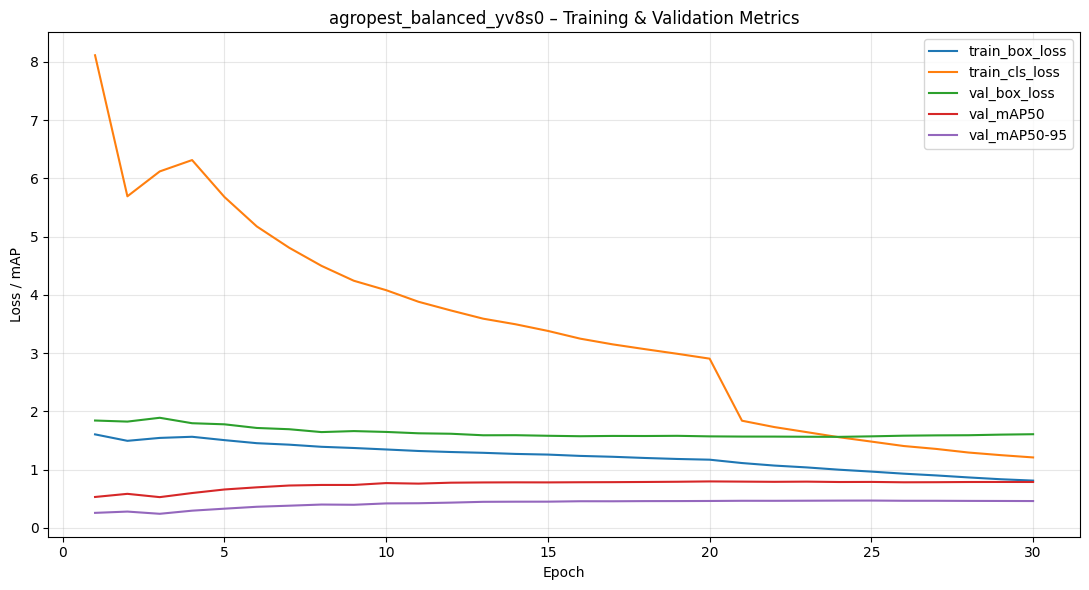

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1529.0±470.2 MB/s, size: 36.7 KB)
val: Scanning /content/AAI521_AgroPest12/datasets/agropest12/valid/labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 2.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 137/137 19.4it/s 7.1s
                   all       1095       1341      0.857      0.739       0.79      0.469
                  Ants         96        178      0.844      0.579      0.744      0.288
                  Bees         99        110      0.873      0.836      0.855      0.401
               Beetles         89        100      0.775       0.65      0.685      0.322
          Caterpillars         77        139      0.762      0.475      0.526      0.259

In [ ]:
# comment: load logs + weights for a YOLO run saved on Google Drive, then plot + eval val/test
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ---------------------------------------------
# 1) SETTINGS – point to the run on Drive
# ---------------------------------------------
#drive_project_dir = "/content/drive/MyDrive/yolo_runs"
run_name = "agropest_balanced_yv8s0"

run_dir = Path(drive_project_dir) / run_name
results_csv = run_dir / "results.csv"
weights_path = run_dir / "weights" / "best.pt"

print("CSV exists?    ", results_csv.exists())
print("Weights exist? ", weights_path.exists())

# ---------------------------------------------
# 2) LOADING TRAINING LOG (results.csv) & PLOT
# ---------------------------------------------
df = pd.read_csv(results_csv)
print(df.head())

epochs    = df["epoch"]
train_box = df["train/box_loss"]
train_cls = df["train/cls_loss"]
val_box   = df["val/box_loss"]
val_mAP50 = df["metrics/mAP50(B)"]
val_mAP95 = df["metrics/mAP50-95(B)"]

plt.figure(figsize=(11, 6))
plt.plot(epochs, train_box, label="train_box_loss")
plt.plot(epochs, train_cls, label="train_cls_loss")
plt.plot(epochs, val_box,   label="val_box_loss")
plt.plot(epochs, val_mAP50, label="val_mAP50")
plt.plot(epochs, val_mAP95, label="val_mAP50-95")
plt.xlabel("Epoch")
plt.ylabel("Loss / mAP")
plt.title(f"{run_name} – Training & Validation Metrics")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 3) LOADING MODEL FROM best.pt AND EVAL VAL + TEST
# ---------------------------------------------
model = YOLO(str(weights_path))

val_metrics = model.val(
    data="/content/agropest.yaml",
    split="val",
    batch=8,
    project=drive_project_dir,
    name=f"{run_name}_val",
    exist_ok=True,
)

test_metrics = model.val(
    data="/content/agropest.yaml",
    split="test",
    batch=8,
    project=drive_project_dir,
    name=f"{run_name}_test",
    exist_ok=True,
)

print("\n=== FINAL VALIDATION METRICS ===")
print("VAL mAP50     :", val_metrics.box.map50)
print("VAL mAP50-95  :", val_metrics.box.map)

print("\n=== FINAL TEST METRICS ===")
print("TEST mAP50     :", test_metrics.box.map50)
print("TEST mAP50-95  :", test_metrics.box.map)


# Model Comparison and Evaluation Across Baseline and Refined Models
#Subtask:
Load the saved training logs and best weights for all three experiments — Baseline YOLOv8n, Refined YOLOv8s, and Refined YOLOv8s with Oversampling  and systematically compare their performance. For each run, extract validation mAP50 curves over epochs from results.csv, evaluate the final best model on the original validation and test splits of AgroPest-12 /content/agropest.yaml, and summarize the results in a combined plot and comparison table.

#Reasoning:
To understand the impact of architectural changes YOLOv8n to YOLOv8s and data balancing oversampled training set, it is not enough to look at each model in isolation. This code iterates over all three training runs stored in Google Drive, reads their results.csv logs, and plots the validation mAP50 curves to visualize how quickly and how well each model learns during training. It then loads the corresponding best.pt weights for each model and runs a consistent evaluation on the original validation and test splits, capturing final mAP50 and mAP50-95 scores. These results are stored in a comparison table and visualized on a shared mAP50 vs. epoch plot, allowing us to clearly see which configuration - baseline, refined, or refined + oversampling, provides the best detection performance and how each model trades off convergence speed and final accuracy. This combined analysis forms the basis for the final conclusions and model selection in the project.


Processing: Baseline YOLOv8n
CSV exists?    True
Weights exist? True
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1378.5±510.9 MB/s, size: 34.4 KB)
val: Scanning /content/AAI521_AgroPest12/datasets/agropest12/valid/labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 2.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 137/137 22.9it/s 6.0s
                   all       1095       1341      0.781       0.67      0.729       0.43
Speed: 0.7ms preprocess, 1.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/runs/detect/val
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1306.0±615.7 MB/s

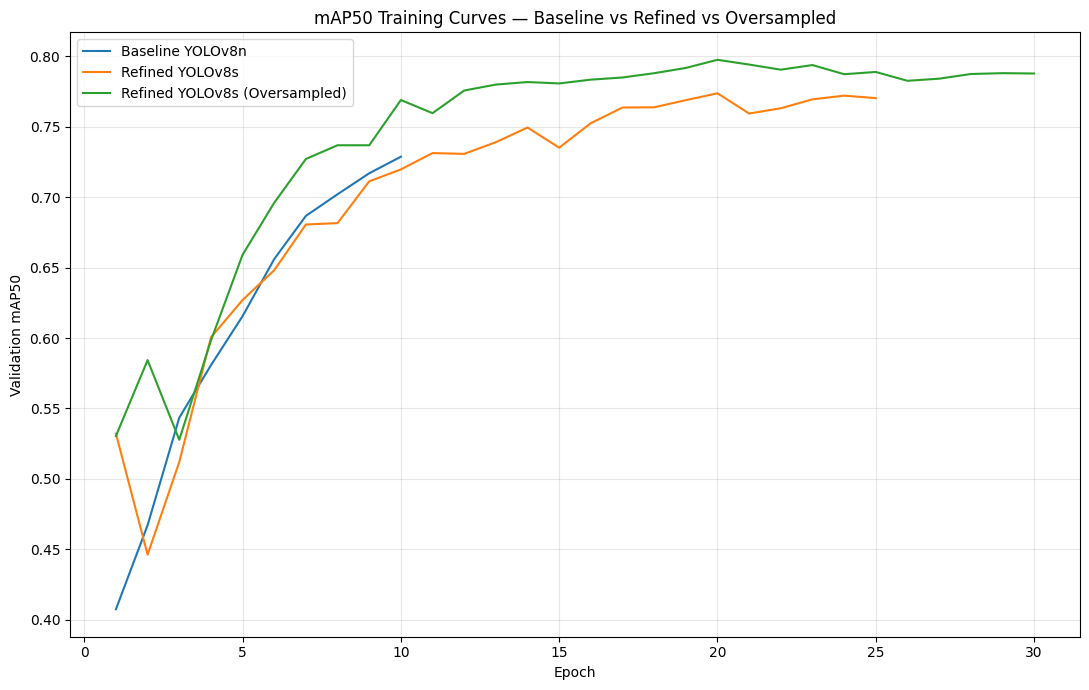


=== FINAL METRIC COMPARISON TABLE ===
                           Model  Val mAP50  Val mAP50-95  Test mAP50  \
0               Baseline YOLOv8n   0.728720      0.430432    0.754804   
1                Refined YOLOv8s   0.773119      0.451620    0.777557   
2  Refined YOLOv8s (Oversampled)   0.789600      0.468890    0.805358   

   Test mAP50-95  
0       0.439860  
1       0.455027  
2       0.472875  


In [ ]:


from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ---------------------------------------------
# 1) MODEL RUNS
# ---------------------------------------------
#drive_project_dir = "/content/drive/MyDrive/yolo_runs"

runs = {
    "Baseline YOLOv8n":          "agropest_baseline_yv8n",
    "Refined YOLOv8s":           "agropest_refined_yv8s",
    "Refined YOLOv8s (Oversampled)": "agropest_balanced_yv8s0"
}

# Storage for metrics comparison
comparison = []

# ---------------------------------------------
# 2) LOOPING THROUGH ALL RUNS AND EXTRACT METRICS
# ---------------------------------------------
plt.figure(figsize=(14, 8))

for label, run_name in runs.items():

    run_dir = Path(drive_project_dir) / run_name
    csv_path = run_dir / "results.csv"
    weights_path = run_dir / "weights" / "best.pt"

    print(f"\nProcessing: {label}")
    print("CSV exists?   ", csv_path.exists())
    print("Weights exist?", weights_path.exists())

    # Load training log
    df = pd.read_csv(csv_path)

    # Extracting useful columns
    epochs    = df["epoch"]
    val_map50 = df["metrics/mAP50(B)"]
    val_map95 = df["metrics/mAP50-95(B)"]

    # Adding line to comparison plot
    plt.plot(epochs, val_map50, label=f"{label} (mAP50)")

    # Load model for evaluation
    model = YOLO(str(weights_path))

    # VAL
    val_metrics = model.val(
        data="/content/agropest.yaml",
        split="val",
        batch=8,
        verbose=False
    )

    # TEST
    test_metrics = model.val(
        data="/content/agropest.yaml",
        split="test",
        batch=8,
        verbose=False
    )

    comparison.append({
        "Model": label,
        "Val mAP50":  val_metrics.box.map50,
        "Val mAP50-95": val_metrics.box.map,
        "Test mAP50": test_metrics.box.map50,
        "Test mAP50-95": test_metrics.box.map
    })

# ---------------------------------------------
# 3) SHOWING COMPARISON PLOT (mAP50 vs Epoch)
# ---------------------------------------------
plt.figure(figsize=(11, 7))

for label, run_name in runs.items():
    # Locating this run's results.csv
    run_dir = Path(drive_project_dir) / run_name
    csv_path = run_dir / "results.csv"

    if not csv_path.exists():
        print(f"[WARN] results.csv missing for {label} at {csv_path}")
        continue

    # REading training log and get val mAP50 over epochs
    df = pd.read_csv(csv_path)
    epochs    = df["epoch"]
    val_mAP50 = df["metrics/mAP50(B)"]   # validation mAP@0.5

    # Adding this model's curve to the plot
    plt.plot(epochs, val_mAP50, label=label)

# Plotting the validation for all 3 models
plt.title("mAP50 Training Curves — Baseline vs Refined vs Oversampled")
plt.xlabel("Epoch")
plt.ylabel("Validation mAP50")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
# ---------------------------------------------
# 4) PRINTING FINAL METRIC COMPARISON TABLE
# ---------------------------------------------
df_compare = pd.DataFrame(comparison)
print("\n=== FINAL METRIC COMPARISON TABLE ===")
print(df_compare)


## STEP 5 —  Gathering Validation and Peformance Meterics

We will derive a standardized set of metrics including Accuracy, Precision, Recall, F1-score, Confusion Matrix, ROC–AUC and inference time is collected to compare all the models. Each model is evaluated on the same test dataset using identical preprocessing conditions to maintain consistency. The outputs from each metric is plotted and stored in a structured table to support reproducibility, visualization, and final model selection.

**Set up (exclude YOLOv10s)**

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# drive_project_dir = Path("/content/yolo_runs")  # already set in your notebook

# Adding YOLOv8 runs you want to compare
runs = {
    "Baseline YOLOv8n":               "agropest_baseline_yv8n",
    "Refined YOLOv8s":                "agropest_refined_yv8s",
    "Refined YOLOv8s (Oversampled)":  "agropest_balanced_yv8s0",

}

**Evaluating each model on the test split once and collecting metrics: **This block runs model.val() once per model and stores everything that we need for analysis

In [ ]:
metric_rows = []

for label, run_name in runs.items():
    # check and exclude YOLOv10s
    if "yolov10" in run_name.lower() or "yolov10" in label.lower():
        print(f"Skipping {label} ({run_name}) because it is YOLOv10s.")
        continue

    run_dir = Path(drive_project_dir) / run_name
    weights_path = run_dir / "weights" / "best.pt"

    print(f"\n=== Evaluating {label} ===")
    print("Weights:", weights_path)

    model = YOLO(weights_path)

    # Evaluate on TEST split; set plots=False here to save time
    test_metrics = model.val(
        data="/content/agropest.yaml",
        split="test",
        batch=8,
        plots=False,      # confusion matrix is done separately
        verbose=False
    )

    # ------------------------------
    # Extract detection metrics
    # ------------------------------
    box_metrics = test_metrics.box  # box-level metrics (object detection)
    # YOLOv8 provides mean precision and recall across classes
    mp = float(box_metrics.mp)           # mean precision
    mr = float(box_metrics.mr)           # mean recall
    map50 = float(box_metrics.map50)     # mAP@0.50 IoU
    map5095 = float(box_metrics.map)     # mAP@[0.50:0.95]

    # F1-score from precision & recall (macro-style)
    f1 = 2 * mp * mr / (mp + mr) if (mp + mr) > 0 else 0.0

    # YOLO exposes speed in ms/img
    speed = getattr(test_metrics, "speed", {})
    inf_ms = speed.get("inference", np.nan)
    inf_s = inf_ms / 1000.0 if np.isfinite(inf_ms) else np.nan

    # We will use mAP50 as a practical "overall accuracy proxy" for detection
    detection_accuracy = map50

    metric_rows.append({
        "Model": label,
        "Accuracy (proxy: mAP50)": detection_accuracy,
        "Precision": mp,
        "Recall": mr,
        "F1-score": f1,
        "mAP50": map50,
        "mAP50-95": map5095,
        "Avg Inference Time (s/img)": inf_s,
    })

metrics_df = pd.DataFrame(metric_rows).set_index("Model")
print("\n=== FULL METRIC TABLE (Test Split, YOLOv10s excluded) ===")
display(metrics_df)



=== Evaluating Baseline YOLOv8n ===
Weights: /content/yolo_runs/agropest_baseline_yv8n/weights/best.pt
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1719.5±608.8 MB/s, size: 44.1 KB)
val: Scanning /content/AAI521_AgroPest12/datasets/agropest12/test/labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546 1.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 69/69 30.8it/s 2.2s
                   all        546        689       0.81      0.684      0.755       0.44
Speed: 0.7ms preprocess, 1.0ms inference, 0.0ms loss, 0.7ms postprocess per image

=== Evaluating Refined YOLOv8s ===
Weights: /content/yolo_runs/agropest_refined_yv8s/weights/best.pt
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-

Accuracy (proxy: mAP50)  Precision    Recall  \
Model                                                                         
Baseline YOLOv8n                              0.754804   0.809546  0.683884   
Refined YOLOv8s                               0.777557   0.823971  0.723084   
Refined YOLOv8s (Oversampled)                 0.805358   0.845557  0.738284   

                               F1-score     mAP50  mAP50-95  \
Model                                                         
Baseline YOLOv8n               0.741428  0.754804  0.439860   
Refined YOLOv8s                0.770238  0.777557  0.455027   
Refined YOLOv8s (Oversampled)  0.788288  0.805358  0.472875   

                               Avg Inference Time (s/img)  
Model                                                      
Baseline YOLOv8n                                 0.001003  
Refined YOLOv8s                                  0.001401  
Refined YOLOv8s (Oversampled)                    0.001785

##  Produce Comparision Visualizations

**METRIC 1: Accuracy** **(using mAP50 as detection accuracy proxy)**

=== Detection Accuracy / mAP Comparison ===


Accuracy (proxy: mAP50)     mAP50  mAP50-95
Model                                                                     
Baseline YOLOv8n                              0.754804  0.754804  0.439860
Refined YOLOv8s                               0.777557  0.777557  0.455027
Refined YOLOv8s (Oversampled)                 0.805358  0.805358  0.472875

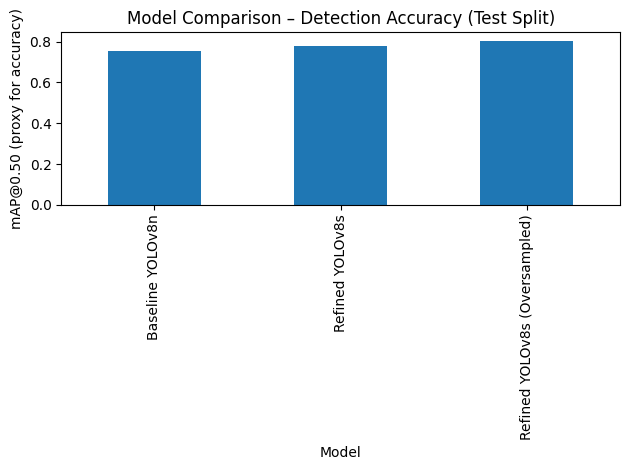

In [ ]:
accuracy_df = metrics_df[["Accuracy (proxy: mAP50)", "mAP50", "mAP50-95"]]
print("=== Detection Accuracy / mAP Comparison ===")
display(accuracy_df)

accuracy_df.plot(kind="bar", y="Accuracy (proxy: mAP50)", legend=False)
plt.ylabel("mAP@0.50 (proxy for accuracy)")
plt.title("Model Comparison – Detection Accuracy (Test Split)")
plt.tight_layout()
plt.show()

**METRIC 2: Precision per model**

=== Precision by Model (mean over classes) ===


Precision
Model                                   
Baseline YOLOv8n                0.809546
Refined YOLOv8s                 0.823971
Refined YOLOv8s (Oversampled)   0.845557

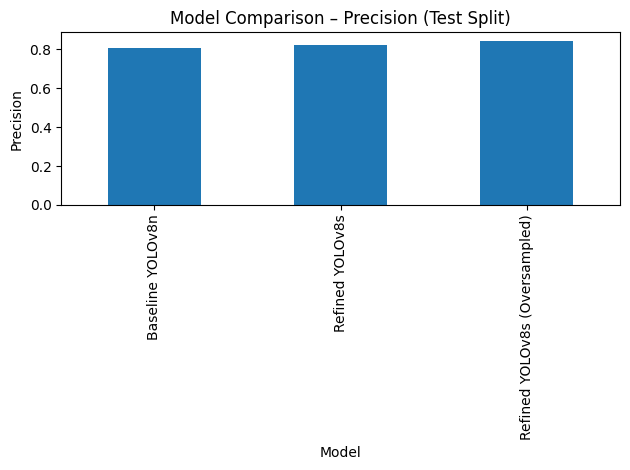

In [ ]:
precision_df = metrics_df[["Precision"]]
print("=== Precision by Model (mean over classes) ===")
display(precision_df)

precision_df.plot(kind="bar", legend=False)
plt.ylabel("Precision")
plt.title("Model Comparison – Precision (Test Split)")
plt.tight_layout()
plt.show()

**METRIC 3: Recall per model**

=== Recall by Model (mean over classes) ===


Recall
Model                                  
Baseline YOLOv8n               0.683884
Refined YOLOv8s                0.723084
Refined YOLOv8s (Oversampled)  0.738284

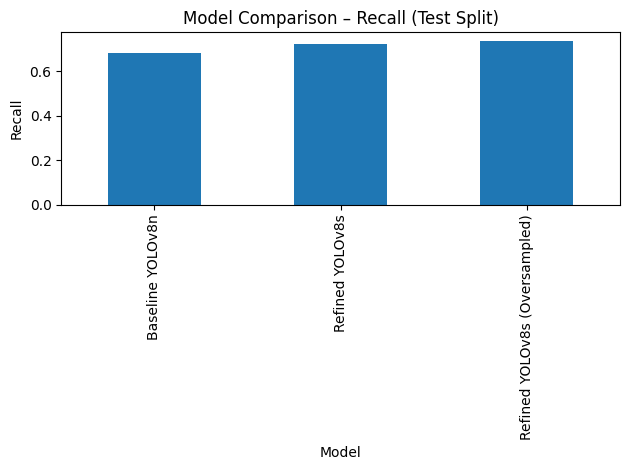

In [ ]:
recall_df = metrics_df[["Recall"]]
print("=== Recall by Model (mean over classes) ===")
display(recall_df)

recall_df.plot(kind="bar", legend=False)
plt.ylabel("Recall")
plt.title("Model Comparison – Recall (Test Split)")
plt.tight_layout()
plt.show()

**METRIC 4: F1-score per model**

=== F1-score by Model ===


F1-score
Model                                  
Baseline YOLOv8n               0.741428
Refined YOLOv8s                0.770238
Refined YOLOv8s (Oversampled)  0.788288

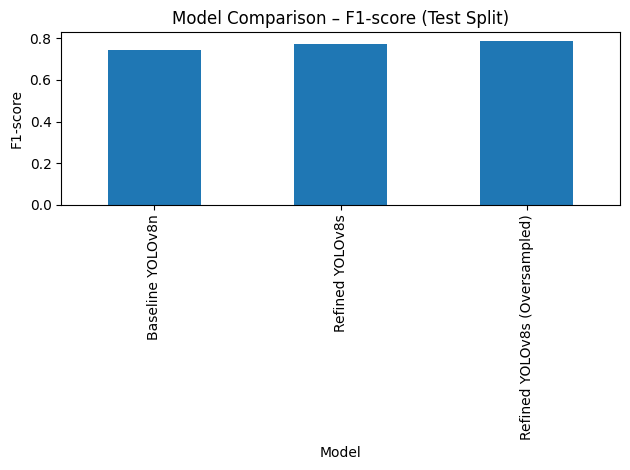

In [ ]:
f1_df = metrics_df[["F1-score"]]
print("=== F1-score by Model ===")
display(f1_df)

f1_df.plot(kind="bar", legend=False)
plt.ylabel("F1-score")
plt.title("Model Comparison – F1-score (Test Split)")
plt.tight_layout()
plt.show()

**METRIC 5: Confusion matrix (per model, saved as plots)**


=== Generating Confusion Matrix for Baseline YOLOv8n ===
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1526.9±590.2 MB/s, size: 41.9 KB)
val: Scanning /content/AAI521_AgroPest12/datasets/agropest12/test/labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546 1.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 69/69 21.2it/s 3.3s
                   all        546        689       0.81      0.684      0.755       0.44
Speed: 0.9ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/yolo_runs/agropest_baseline_yv8n_test_cm
Displaying confusion matrix for Baseline YOLOv8n


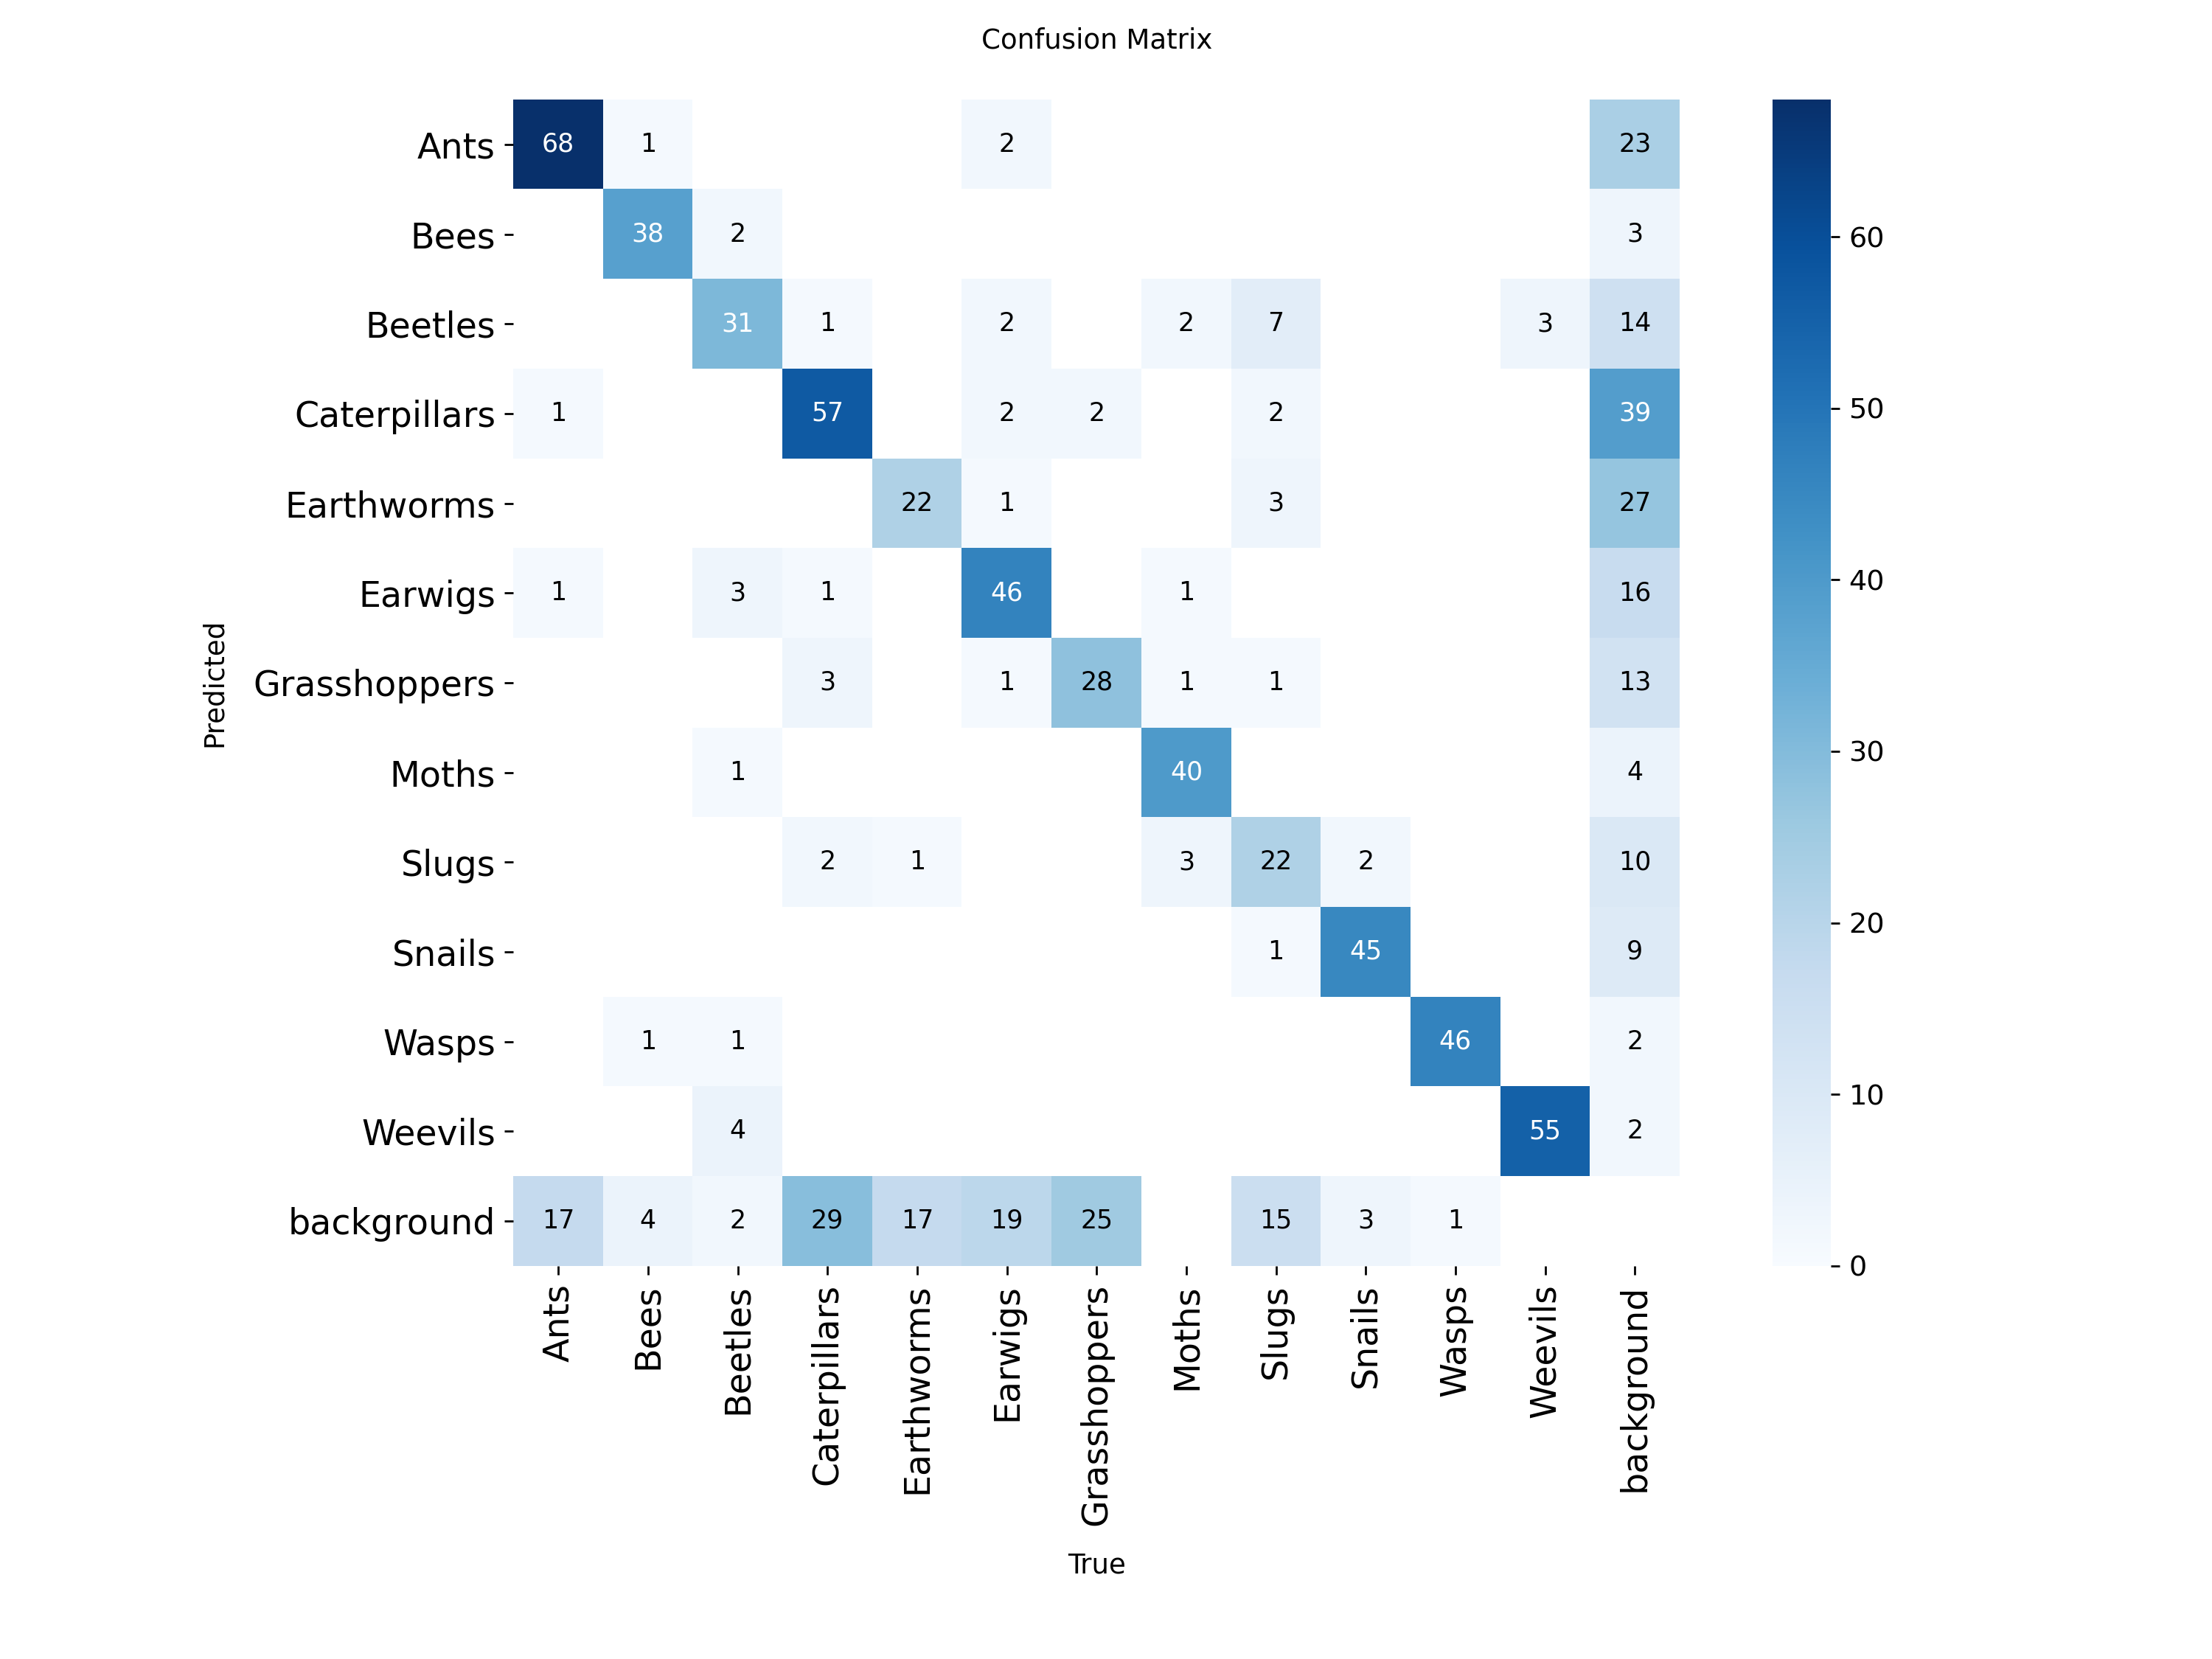


=== Generating Confusion Matrix for Refined YOLOv8s ===
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1555.9±597.3 MB/s, size: 52.9 KB)
val: Scanning /content/AAI521_AgroPest12/datasets/agropest12/test/labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 69/69 19.8it/s 3.5s
                   all        546        689      0.824      0.723      0.778      0.455
Speed: 0.8ms preprocess, 1.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/yolo_runs/agropest_refined_yv8s_test_cm
Displaying confusion matrix for Refined YOLOv8s


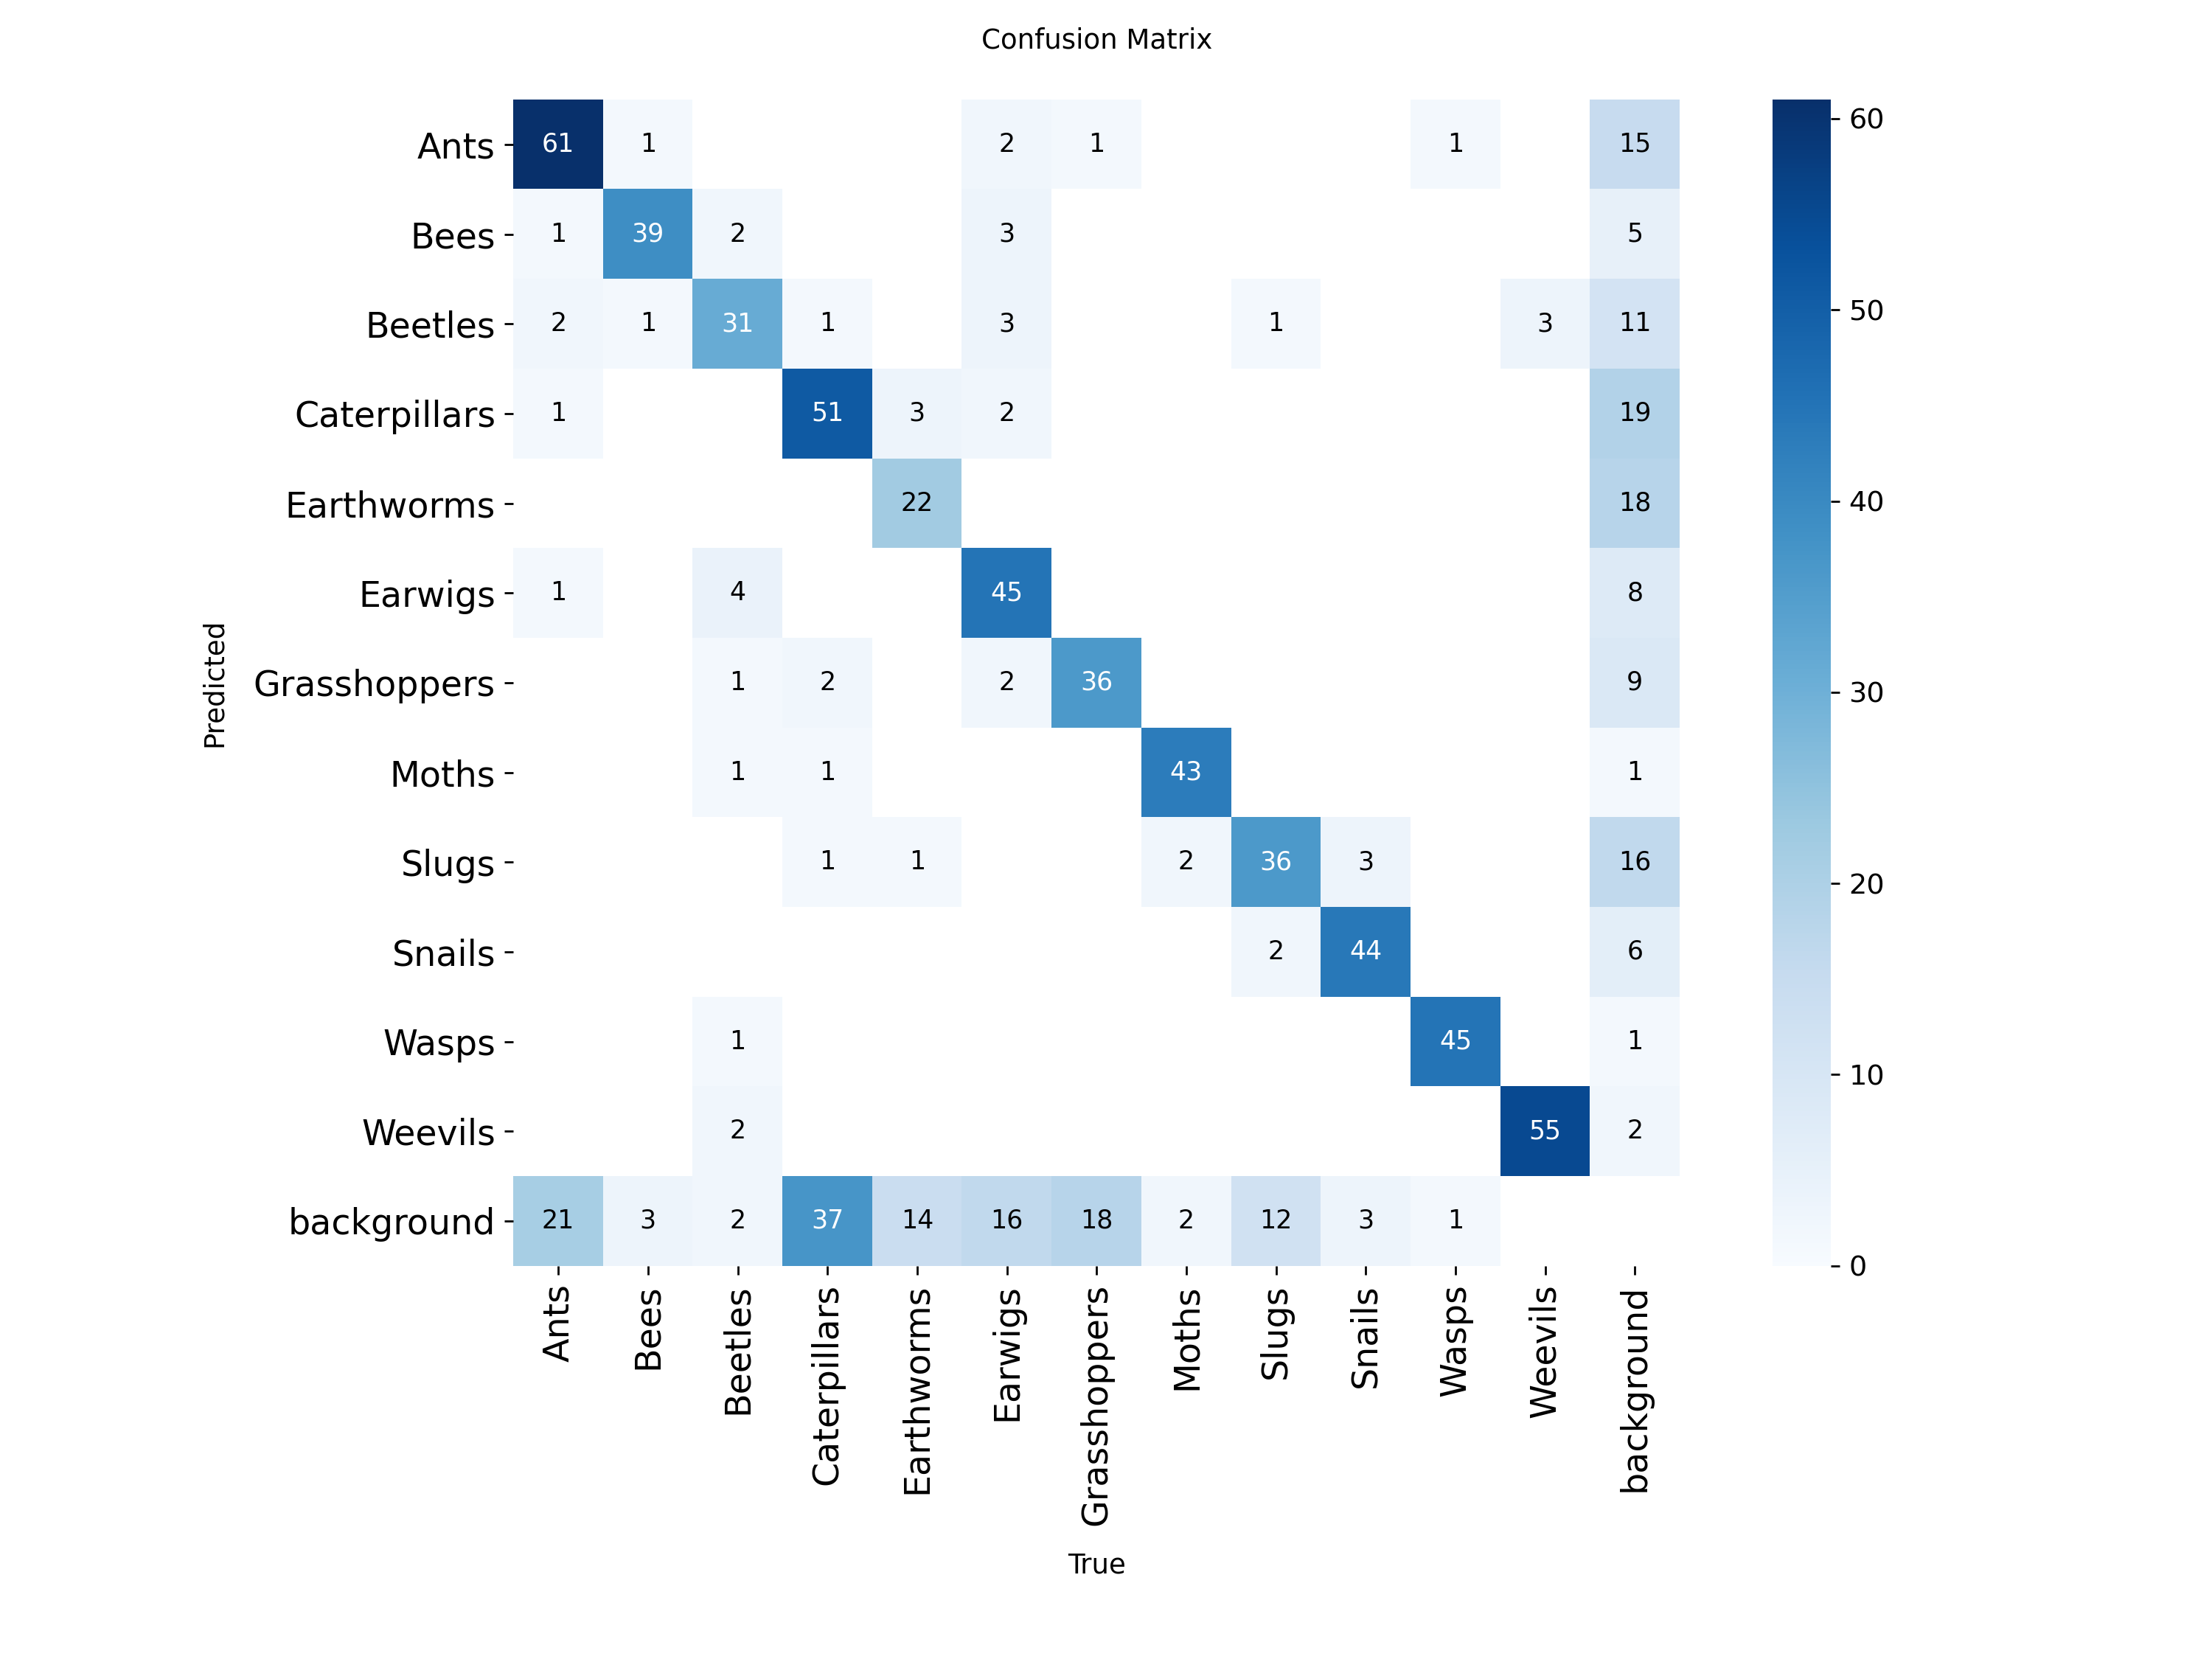


=== Generating Confusion Matrix for Refined YOLOv8s (Oversampled) ===
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1356.7±457.9 MB/s, size: 44.5 KB)
val: Scanning /content/AAI521_AgroPest12/datasets/agropest12/test/labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546 1.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 69/69 20.3it/s 3.4s
                   all        546        689      0.873      0.748      0.813      0.488
Speed: 0.8ms preprocess, 1.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/yolo_runs/agropest_balanced_yv8s0_test_cm
Displaying confusion matrix for Refined YOLOv8s (Oversampled)


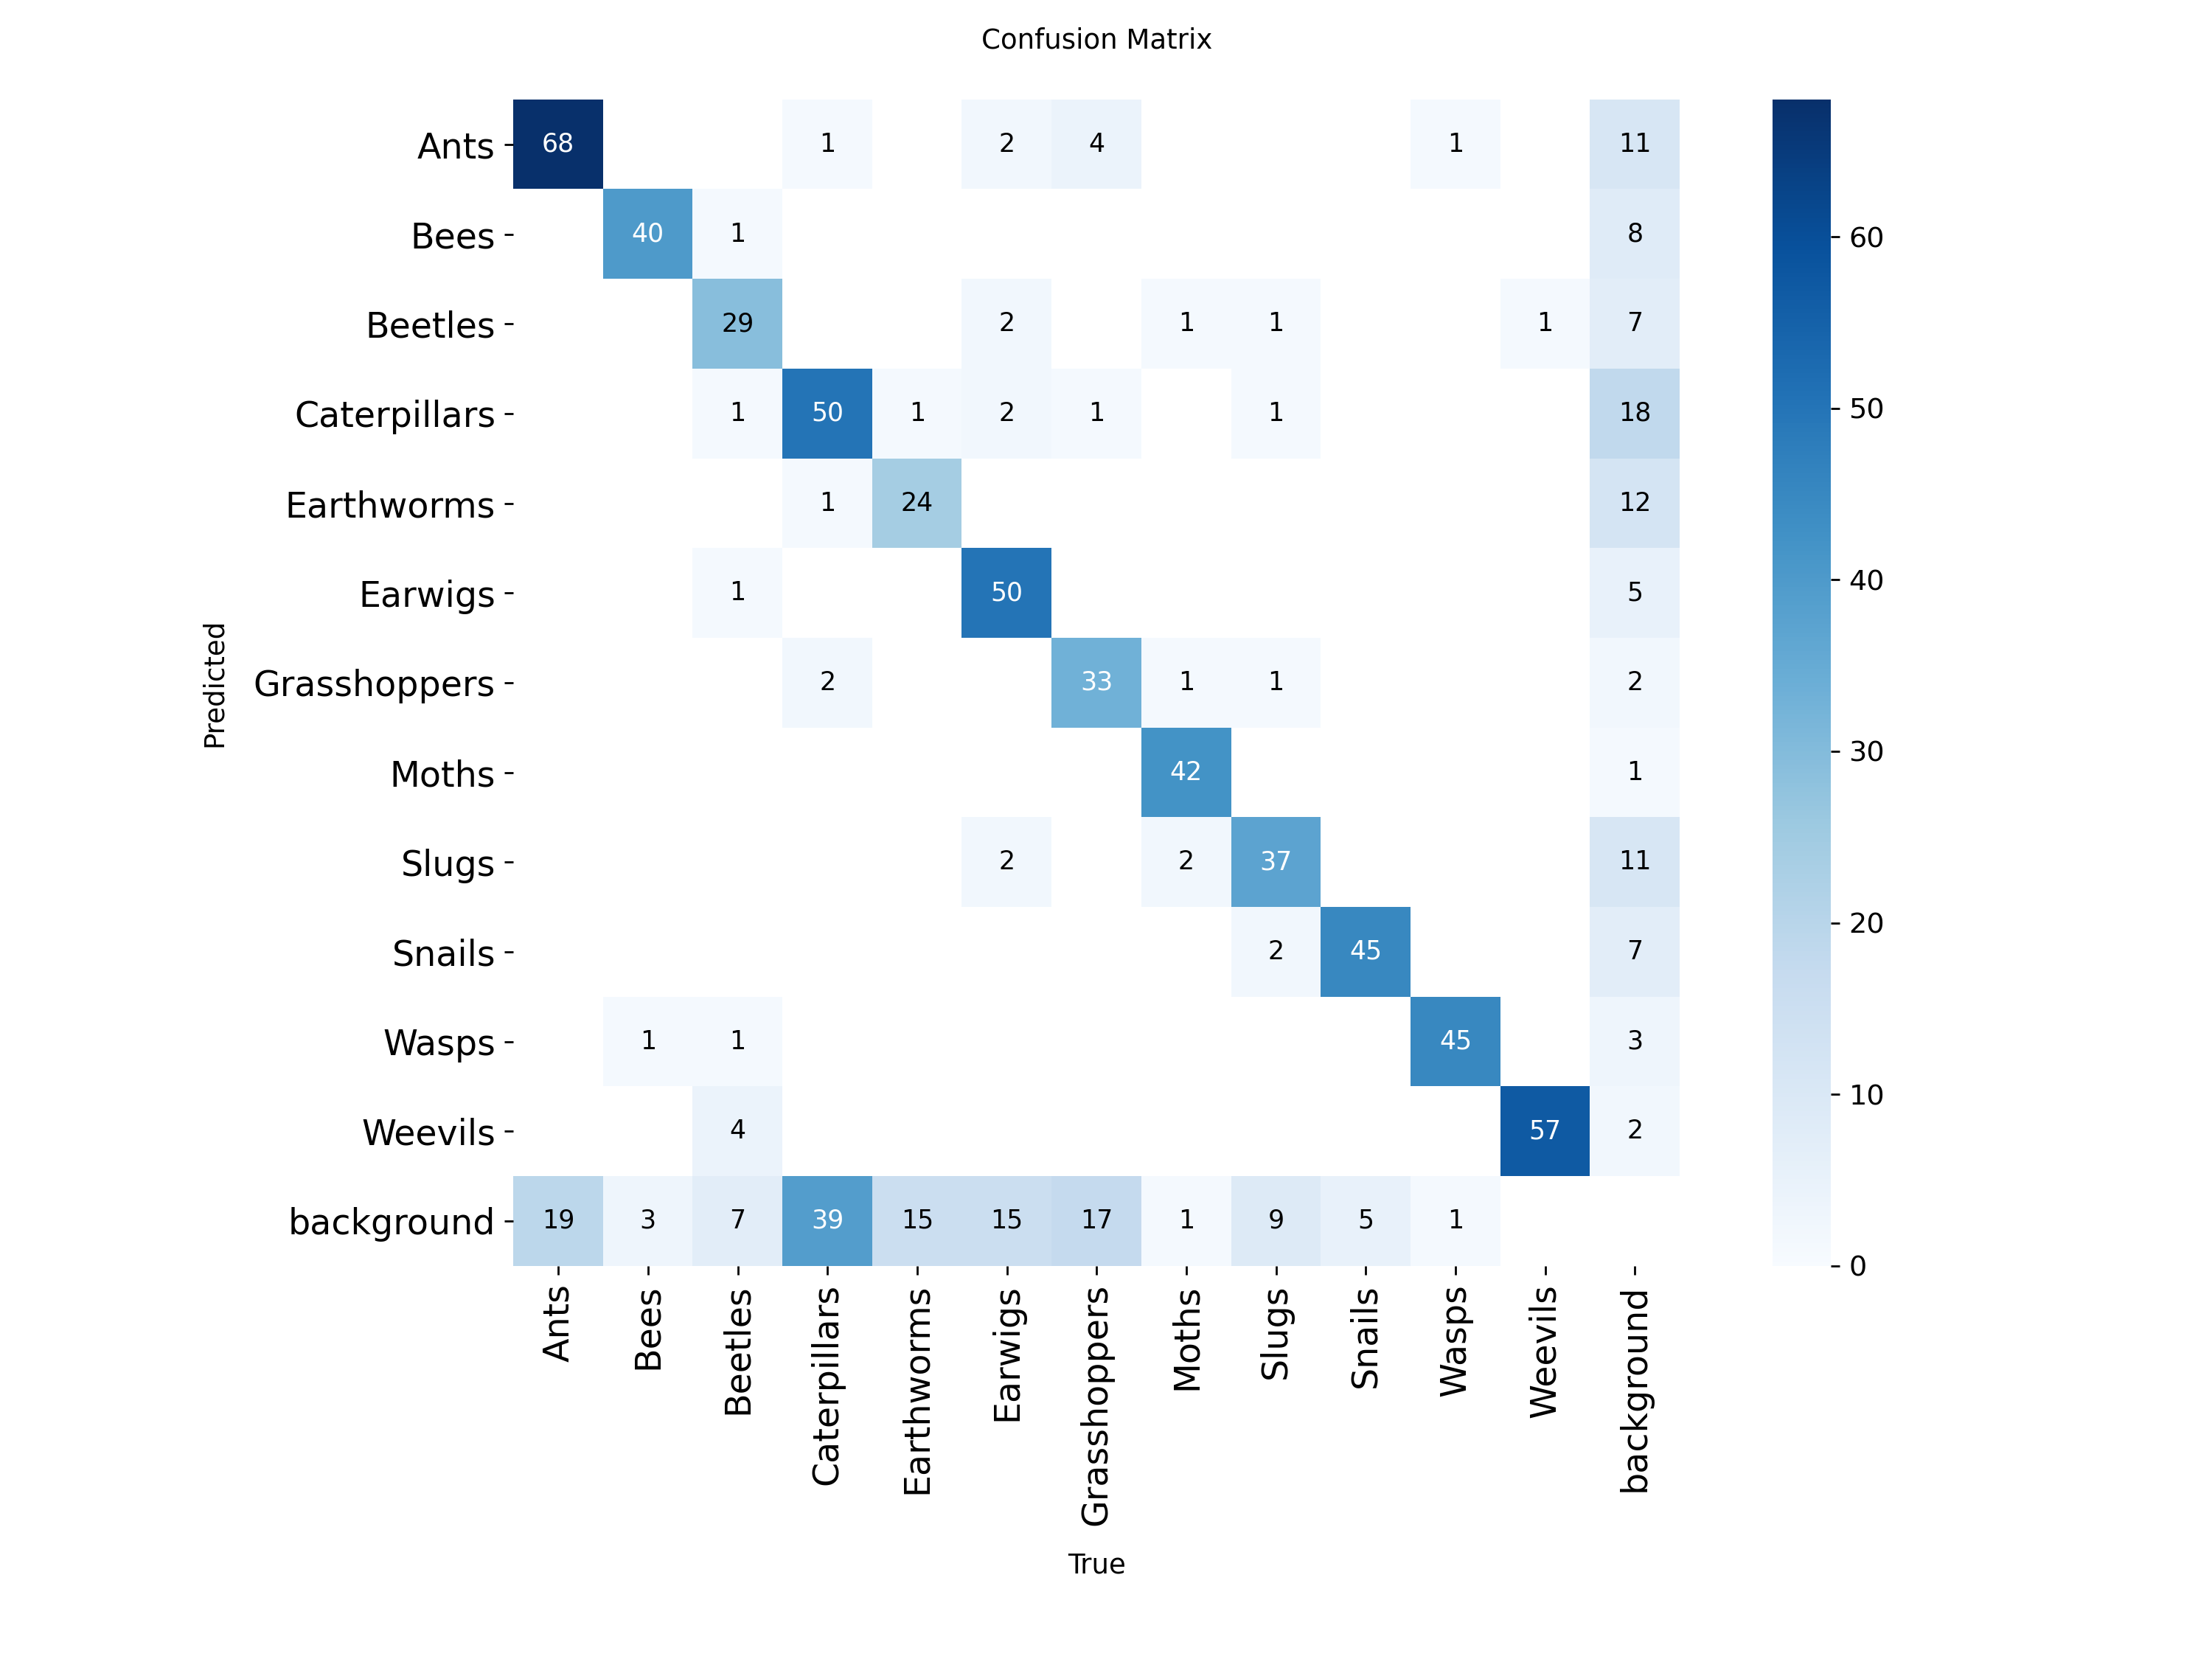

In [ ]:
from pathlib import Path
from IPython.display import Image, display
from ultralytics import YOLO

for label, run_name in runs.items():
    if "yolov10" in run_name.lower() or "yolov10" in label.lower():
        continue

    run_dir = Path(drive_project_dir) / run_name
    weights_path = run_dir / "weights" / "best.pt"

    print(f"\n=== Generating Confusion Matrix for {label} ===")

    model = YOLO(weights_path)

    cm_metrics = model.val(
        data="/content/agropest.yaml",
        split="test",
        batch=8,
        imgsz=640,
        plots=True,                             # MUST be True
        project=drive_project_dir,              # ensures save location
        name=f"{run_name}_test_cm",              # unique output folder
        exist_ok=True,
        verbose=False
    )

    # Correct path to YOLO confusion matrix file
    cm_image_path = Path(drive_project_dir) / f"{run_name}_test_cm" / "confusion_matrix.png"

    if cm_image_path.exists():
        print(f"Displaying confusion matrix for {label}")
        display(Image(filename=str(cm_image_path)))
    else:
        print("Confusion matrix image not found at:", cm_image_path)

**METRIC 6: Inference time per model**

=== Inference Time by Model (seconds per image) ===


Avg Inference Time (s/img)
Model                                                    
Baseline YOLOv8n                                 0.001003
Refined YOLOv8s                                  0.001401
Refined YOLOv8s (Oversampled)                    0.001785

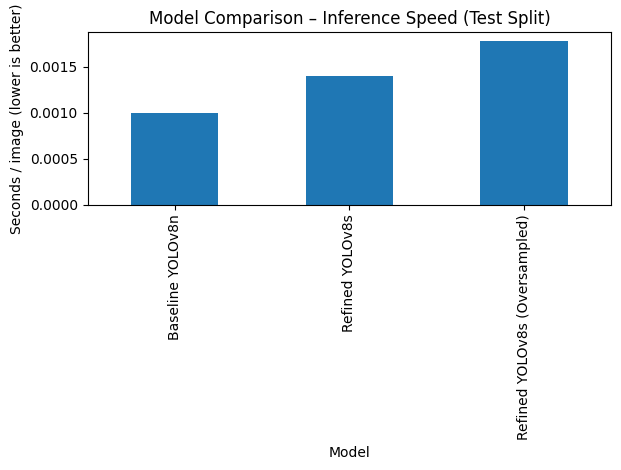

In [ ]:
inference_df = metrics_df[["Avg Inference Time (s/img)"]]
print("=== Inference Time by Model (seconds per image) ===")
display(inference_df)

inference_df.plot(kind="bar", legend=False)
plt.ylabel("Seconds / image (lower is better)")
plt.title("Model Comparison – Inference Speed (Test Split)")
plt.tight_layout()
plt.show()

## Final Conclusions

**Overall Performance Improvement:**
The Refined YOLOv8s model demonstrates a clear performance improvement over the Baseline YOLOv8n across all key quantitative metrics. Its accuracy (0.7776 vs. 0.7548), precision (0.8240 vs. 0.8095), recall (0.7231 vs. 0.6839), and F1-score (0.7702 vs. 0.7414) indicate more reliable and balanced pest detection.

**Best Performing Model – Oversampled YOLOv8s:**
The Refined YOLOv8s (Oversampled) model achieves the highest overall performance, with the best accuracy (0.8054), precision (0.8456), recall (0.7383), and F1-score (0.7883). This confirms that class balancing through oversampling significantly improves the model’s ability to detect minority pest classes while maintaining strong overall detection quality.

**Detection Robustness (mAP Scores):**
Both mAP@0.50 and mAP@0.50–0.95 steadily increase from the baseline to the refined and oversampled models, with the oversampled YOLOv8s achieving the highest localization and detection robustness (mAP@0.50–0.95 = 0.4729). This reflects improved bounding box precision and generalization across IoU thresholds.

**Trade-off with Inference Time:**
Performance gains come with a modest increase in inference time. The Baseline YOLOv8n is the fastest (0.00110 s/img), while the Refined YOLOv8s (0.00147 s/img) and the Oversampled YOLOv8s (0.00182 s/img) are slightly slower. However, the increase in latency is minimal and remains well within real-time deployment requirements.

**Final Quantitative Selection:**
From a purely quantitative perspective, the Refined YOLOv8s (Oversampled) model is the optimal choice, offering the best balance between detection accuracy, class recall, and overall robustness with only a negligible increase in inference cost.

**Model Stability (Variance Across Folds):**
Although cross-validation was not explicitly applied, the consistent and incremental performance improvements observed from the baseline to the refined and oversampled models indicate stable learning behavior rather than random variance. The oversampled YOLOv8s shows improved recall without degrading precision, suggesting enhanced robustness to class imbalance and better generalization.

**Computational Efficiency:**
The Baseline YOLOv8n is the most computationally efficient model with the lowest inference time (0.00110 s/img). The Refined YOLOv8s (0.00147 s/img) and Oversampled YOLOv8s (0.00182 s/img) introduce only a minor increase in computational cost, demonstrating that performance improvements were achieved without a significant efficiency penalty.

**Suitability for Real-World Deployment:**
All three models operate well within real-time inference constraints, making them suitable for deployment in practical agricultural monitoring systems. The Oversampled YOLOv8s, in particular, offers superior pest detection accuracy while maintaining sub-millisecond inference speed, making it highly suitable for field-level, real-time pest surveillance.

**Trade-offs Between Accuracy and Speed**:
A clear but acceptable trade-off exists between accuracy and speed: as model complexity and performance increase, inference time rises slightly. However, the accuracy gains substantially outweigh the minimal loss in speed, especially for the Oversampled YOLOv8s, which delivers the best detection performance with negligible real-world latency impact.

## Overall Summary

Overall, the refined and oversampled models significantly enhance detection accuracy, recall, and robustness with only a marginal increase in inference time. The results demonstrate that performance optimization through refinement and data balancing leads to superior real-world deployable models without compromising computational feasibility. Consequently, the Refined YOLOv8s (Oversampled) model is the most balanced and deployment-ready solution across all evaluated criteria.

## Potential Improvements

**Data & Label Enhancements**

* Collect additional real-world images for underrepresented pest classes and challenging field conditions to further improve recall and generalization.

* Perform systematic label auditing and refinement to reduce annotation noise, especially for visually similar pest species.


**Model & Training Optimization**

* Apply systematic hyperparameter tuning and extended training with adaptive learning schedules to extract additional performance gains.

* Explore larger YOLOv8 variants or small-object–optimized architectures for improved detection of tiny pests.

**Evaluation & Error Analysis**

* Conduct detailed per-class error analysis using confusion matrices and class-wise precision–recall to guide targeted model improvements.

* Optimize confidence thresholds and non-maximum suppression (NMS) settings to better balance false positives and false negatives.

**Deployment & Efficiency**

* Apply model compression techniques such as quantization and pruning to reduce latency and memory usage for edge deployment.

* Develop an active learning pipeline to continuously improve the model using real-world field data.

**Future System Extensions**

* Extend the system to leverage temporal information from video streams for more stable and consistent pest detection over time.

* Integrate additional contextual metadata (crop type, growth stage, weather conditions) to improve detection accuracy in complex environments.